## ${\color{pink}{Start}}$

Garbage Pickups in Russia.

we are going to look only on data that we have for everyday "Ежедневно"

The main Data is going to be the FactVolumes which represents the amount of trash picked up from each container everyday (meter^3)

Also we will see how the Temperature will affect the trash pickups and the amount

In [224]:
import numpy as np
import pandas as pd
import random as rnd
import statistics

# import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import periodogram
from scipy.signal import welch

from statsmodels.tsa.stattools import acf
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_process import arma_acf
from statsmodels.tsa.arima_process import arma_generate_sample as arma_gen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from tqdm import tqdm
from statsmodels.tsa.statespace import sarimax
from arch import arch_model
from statsmodels.tsa.arima_process import arma_generate_sample



%matplotlib inline

import ast
from datetime import datetime
import pmdarima as pm 
import warnings
warnings.filterwarnings("ignore")
#pip install pandas openpyxl

In [82]:
trash_all = pd.read_excel(r"volume_report_2022_2024.xlsx", sheet_name=None)
temp_trash = pd.read_excel(r"irkutsk.xlsx")

In [83]:
excel_sheets = ["2022", "2023-1", "2023-2", "2024-1", "2024-2"]

# in order to find how to write "Ежедневно" : The_Trash.iloc[500:515,:]

In [84]:
trash_all["2024-1"].head(2)

containerGroupId parentRegionName regionName  lotName  \
0  13f19158-13f7-40f1-a25b-33c558642257   Аларский район      Аларь      NaN   
1  b4c9d52d-a152-4742-8b2f-4722115f14ac   Аларский район      Аларь      NaN   

   containerAreaCode                   address        ownerCompanyName amount  \
0         38122268.0  д .Куркат, Молодежная, 2  Администрация МО Аларь      3   
1         38122268.0  д .Куркат, Молодежная, 2  Администрация МО Аларь      3   

  volume  tripsPerDay           schedule  \
0   0.75          NaN  1-й и 3-й четверг   
1   0.75          NaN  1-й и 3-й четверг   

                              removalDateAppTzTruncs  \
0  ['2024-01-04T00:00', '2024-01-18T00:00', '2024...   
1  ['2024-06-06T00:00', '2024-06-20T00:00', '2024...   

                      factAmounts  \
0  [3, 1, 0, 3, 0, 3, 3, 3, 1, 3]   
1              [0, 0, 3, 0, 0, 0]   

                                         factVolumes  \
0  [2.25, 0.75, 0, 2.25, 0, 2.25, 2.25, 2.25, 0.7...   
1                              [0, 0, 2.25, 0, 0, 0]   

                                 factVolumesNoPickup  \
0  [2.25, 0.75, 0, 2.25, 0, 2.25, 2.25, 2.25, 0.7...   
1                              [0, 0, 2.25, 0, 0, 0]   

                      factPickups  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1              [0, 0, 0, 0, 0, 0]

In [85]:
for sheet in excel_sheets:
    trash_all[sheet] = trash_all[sheet].drop(['containerGroupId', 'parentRegionName', 'lotName', 'ownerCompanyName', 'amount', 'volume',
                                              'tripsPerDay', 'factAmounts',  'factVolumesNoPickup', 'factPickups'], axis=1)

    trash_all[sheet]["removalDateAppTzTruncs"] = trash_all[sheet]["removalDateAppTzTruncs"].str.replace("T00:00", "", regex=False)

In [86]:
for sheet in excel_sheets:
    trash_all[sheet] = trash_all[sheet].loc[trash_all[sheet]["schedule"] == "Ежедневно"]

In [87]:
trash_all["2024-1"].head()

regionName  containerAreaCode                     address   schedule  \
969    Кутулик         38110846.0       Кутулик, Матросова,18  Ежедневно   
970    Кутулик         38110846.0       Кутулик, Матросова,18  Ежедневно   
973    Кутулик         38110846.0       Кутулик, Матросова,18  Ежедневно   
982    Кутулик         38110868.0  Кутулик, Механизаторов, 13  Ежедневно   
983    Кутулик         38110868.0  Кутулик, Механизаторов, 13  Ежедневно   

                                removalDateAppTzTruncs  \
969  ['2023-12-22', '2023-12-23', '2023-12-24', '20...   
970  ['2024-03-04', '2024-03-05', '2024-03-06', '20...   
973  ['2024-05-21', '2024-05-22', '2024-05-23', '20...   
982  ['2024-03-04', '2024-03-05', '2024-03-06', '20...   
983  ['2024-05-21', '2024-05-22', '2024-05-23', '20...   

                                           factVolumes  
969  [0.75, 0.75, 3.75, 3.75, 0, 0.75, 1.5, 2.25, 1...  
970  [0, 3.75, 1.5, 0.75, 1.5, 1.5, 0, 2.25, 2.25, ...  
973  [3.75, 0, 0, 0, 0, 0, 3.75, 3.75, 0, 4.5, 3, 0...  
982  [0, 3, 0, 0.75, 2.25, 0.75, 0.75, 0.75, 0.75, ...  
983  [3, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0.75, 0, 3, 0, ...

# ${\color{pink}{Temprature}}$

In [88]:
# We dont need all the INFORMATION in the temp file...
temperature_file = temp_trash.drop([
    'plan_value_hps', 'plan_value_tps',
    'tech_min_hps', 'tech_min_tps', 'technology_min_hps',
    'technology_min_tps', 'tech_max_hps', 'tech_max_tps', 'plan_value',
    'plan_exp', 'plan_imp', 'price_demand', 'price_supply',
    'ov_plan_value', 'infl', 'price_demand_real',
    'price_supply_real', 'real_usd_rub', 'oil_rub_real',
    'coal_rub_real', 'al_rub_real', 'steel_rub_real', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'holiday',
    'weather_u', 'weather_u3', 'weather_u6', 'weather_u12', 'weather_u24', 'region'
], axis=1)
temperature_file = temperature_file.loc[temperature_file['time'] == "0:00:00"]

In [89]:
temperature_file.head(2)

time       date  weather_t  weather_t3  weather_t6  weather_t12  \
0   0:00:00 2020-11-08   -2.39345   10.767758   13.217213    17.275273   
24  0:00:00 2020-11-09   -0.39345    0.213100    0.701492     1.608606   

    weather_t24  
0     19.075136  
24     0.236162

In [90]:
start_date = "2022-05-05"
end_date = "2024-04-01"
start = temperature_file.loc[temperature_file['date'] == start_date]
end = temperature_file.loc[temperature_file['date'] == end_date]


filtered_data = temperature_file.loc[
    (temperature_file['date'] >= start_date) & (temperature_file['date'] <= end_date)]


size = filtered_data.shape[0]
# t = np.zeros(size)
temperature = []
datee = []
for i in range(size):
    # print(type(float(filtered_data['weather_t'].iloc[i])))
    # t[i] = float(filtered_data['weather_t'].iloc[i])
    temperature.append(float(filtered_data['weather_t'].iloc[i]))
    datee.append(filtered_data['date'].iloc[i].strftime('%Y-%m-%d'))
print(type(temperature))
print(type(temperature[0]))
# print(temperature)
# print(len(temperature))
# print(datee)
print(len(datee))
# print(t.shape)

<class 'list'>
<class 'float'>
696


In [312]:
#because we dont have '2023-08-31' and '2022-08-31'  :)
#we will add the mean temp ...
meany = statistics.mean(temperature)
bad22 =  datee.index('2022-08-30')
bad23 =  datee.index('2023-08-30')
Final_datee = []                        #just to check...
Final_Temperature = []

for i in range(len(temperature)):

    Final_Temperature.append(round(temperature[i],2))
    Final_datee.append(datee[i])

    if i == bad23 or i==bad22 :
        if i == bad22:
            Final_Temperature.append(meany)
            Final_datee.append('2022-08-31')
        if i == bad23:
            Final_Temperature.append(meany)
            Final_datee.append('2023-08-31')


print(type(Final_Temperature))
print(type(Final_Temperature[0]))
print(Final_datee)
print(Final_Temperature)
print(len(Final_Temperature))

<class 'list'>
<class 'float'>
['2022-05-05', '2022-05-06', '2022-05-07', '2022-05-08', '2022-05-09', '2022-05-10', '2022-05-11', '2022-05-12', '2022-05-13', '2022-05-14', '2022-05-15', '2022-05-16', '2022-05-17', '2022-05-18', '2022-05-19', '2022-05-20', '2022-05-21', '2022-05-22', '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26', '2022-05-27', '2022-05-28', '2022-05-29', '2022-05-30', '2022-05-31', '2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10', '2022-06-11', '2022-06-12', '2022-06-13', '2022-06-14', '2022-06-15', '2022-06-16', '2022-06-17', '2022-06-18', '2022-06-19', '2022-06-20', '2022-06-21', '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25', '2022-06-26', '2022-06-27', '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01', '2022-07-02', '2022-07-03', '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11', '2022-07-12', '2

# ${\color{pink}{Getting-The-Right-Dates}}$

In [92]:
def get_the_container(curr_container):

    all_years_data = []
    for sheet in excel_sheets:
        # getting data only for our container in each sheet
        current_sheet = trash_all[sheet].loc[trash_all[sheet]['containerAreaCode'] == curr_container]

        all_years_data.append(current_sheet)

    combined_person = pd.concat(all_years_data, ignore_index=True)  # make it dataforamt
    return combined_person

# ${\color{pink}{Volume}}$

# ${\color{pink}{Last-Battle}}$

--------------

# ${\color{pink}{Our-Time-Series-FINAL :}}$

# ${\color{pink}{מצויין}}$

----

In [93]:
container = [38101724, 38101743, 38102092, 38101779, 38101724, 38101749, 38101607, 38101733, 38101749, 38101523]

# good : 38101724 38101743 38102092 38101779 38101724 38101749 , 38101607 38101733 38101749 38101523
# ok i guess: 38101607 38101733 38101749 38101523

container_try_for_good = []

start_date = "2022-05-05"
end_date = "2024-04-01"
len(container)

10

In [94]:
print(Final_datee)

['2022-05-05', '2022-05-06', '2022-05-07', '2022-05-08', '2022-05-09', '2022-05-10', '2022-05-11', '2022-05-12', '2022-05-13', '2022-05-14', '2022-05-15', '2022-05-16', '2022-05-17', '2022-05-18', '2022-05-19', '2022-05-20', '2022-05-21', '2022-05-22', '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26', '2022-05-27', '2022-05-28', '2022-05-29', '2022-05-30', '2022-05-31', '2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10', '2022-06-11', '2022-06-12', '2022-06-13', '2022-06-14', '2022-06-15', '2022-06-16', '2022-06-17', '2022-06-18', '2022-06-19', '2022-06-20', '2022-06-21', '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25', '2022-06-26', '2022-06-27', '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01', '2022-07-02', '2022-07-03', '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14', '2022

In [95]:
def search_index_of_date(given_date, dates_list):
    try:
        return dates_list.index(given_date)  # Find the index of the given date
    except ValueError:
        return -1  # Return -1 if the date is not found


def get_the_container(curr_container):

    all_years_data = []
    for sheet in excel_sheets:
        # getting data only for our container in each sheet
        current_sheet = trash_all[sheet].loc[trash_all[sheet]['containerAreaCode'] == curr_container]

        all_years_data.append(current_sheet)

    combined_person = pd.concat(all_years_data, ignore_index=True)  # make it dataforamt
    return combined_person

In [96]:
get_the_container(container[0])

regionName  containerAreaCode               address   schedule  \
0  Ленинский район         38101724.0  Розы Люксембург, 219  Ежедневно   
1  Ленинский район         38101724.0  Розы Люксембург, 219  Ежедневно   
2  Ленинский район         38101724.0  Розы Люксембург, 219  Ежедневно   
3  Ленинский район         38101724.0  Розы Люксембург, 219  Ежедневно   
4  Ленинский район         38101724.0  Розы Люксембург, 219  Ежедневно   
5  Ленинский район         38101724.0  Розы Люксембург, 219  Ежедневно   
6  Ленинский район         38101724.0  Розы Люксембург, 219  Ежедневно   
7  Ленинский район         38101724.0  Розы Люксембург, 219  Ежедневно   
8  Ленинский район         38101724.0  Розы Люксембург, 219  Ежедневно   

                              removalDateAppTzTruncs  \
0  ['2021-12-22', '2021-12-26', '2021-12-30', '20...   
1                       ['2021-12-26', '2021-12-28']   
2  ['2022-12-22', '2022-12-23', '2022-12-24', '20...   
3  ['2023-09-17', '2023-09-18', '2023-09-19', '20...   
4  ['2023-06-21', '2023-06-22', '2023-06-23', '20...   
5  ['2023-07-13', '2023-07-14', '2023-07-15', '20...   
6  ['2024-02-14', '2024-02-15', '2024-02-16', '20...   
7  ['2023-12-22', '2023-12-23', '2023-12-24', '20...   
8  ['2024-06-21', '2024-06-22', '2024-06-23', '20...   

                                         factVolumes  
0  [3.3000000000000003, 3.3000000000000003, 4.300...  
1                                         [4.4, 5.5]  
2  [8.8, 9.9, 7.700000000000001, 12.1000000000000...  
3  [9.9, 16.5, 11, 13.2, 7.700000000000001, 12.1,...  
4  [8.8, 9.9, 4.4, 9.9, 9.9, 8.8, 11, 5.5, 9.9, 9...  
5  [12.1, 8.8, 7.700000000000001, 11, 11, 12.1, 1...  
6  [0, 6.6000000000000005, 4.4, 6.600000000000000...  
7  [16.5, 15.4, 4.4, 16.5, 5.5, 5.5, 15.4, 12.1, ...  
8  [5.5, 9.9, 6.6000000000000005, 11, 5.5, 9.9, 5...

In [317]:
# the plan:  finding for each date the vol (698 time hahahahahahahahahah)
# so it means that we are going to go over all the lines in eac container until we find the date and so for all the dates hahahahahahaa
# hahahahahaa
def get_Volumes(curr_container, Final_datee):

    vol_list_all = []
    for q, curr_date in enumerate(Final_datee):  # going over each date (698)

        our_container = get_the_container(curr_container)

        dates_pd = our_container["removalDateAppTzTruncs"]
        Volumes_pd = our_container["factVolumes"]
        lines = len(dates_pd)

    # Time to look for the index of our curr date.
        found_index = -1
        line_index = 0

        while line_index < lines and found_index == -1:
            index_in_list = 0
            Dates_list_line = ast.literal_eval(dates_pd[line_index])
            Volumes_List_line = ast.literal_eval(Volumes_pd[line_index])

            while index_in_list < len(Dates_list_line) and found_index == -1:  # searching for the index of the curr date in this list

                found_index = search_index_of_date(curr_date, Dates_list_line)

                index_in_list = index_in_list + 1

            line_index = line_index + 1

        # print(found_index)
        if found_index < 0:  # if something wrong... we put 0 or mean i dont have time to change it..
            if len(vol_list_all) < 1:
                vol_list_all.append(0)
            else:
                meany = statistics.mean(vol_list_all)
                vol_list_all.append(round(meany, 3))

        else:
            if Volumes_List_line[found_index] > 30:
                if len(vol_list_all) < 1:
                    vol_list_all.append(0)
                else:
                    meany = statistics.mean(vol_list_all)
                    vol_list_all.append(round(meany, 3))
            else:
                curr_Volume = round(Volumes_List_line[found_index], 3)
                vol_list_all.append(curr_Volume)

    return vol_list_all

In [98]:
# get_Volumes(container[0],Final_datee)

In [318]:
all_Vol = np.zeros((10, 1), dtype=object)  # Allow storing lists/arrays

for i in range(len(container)):

    all_Vol[i][0] = get_Volumes(container[i], Final_datee)



In [ ]:

x1 = np.array(all_Vol[0][0])
x2 = np.array(all_Vol[1][0])
x3 = np.array(all_Vol[2][0])
x4 = np.array(all_Vol[3][0])
x5 = np.array(all_Vol[4][0])
x6 = np.array(all_Vol[5][0])
x7 = np.array(all_Vol[6][0])
x8 = np.array(all_Vol[7][0])
x9 = np.array(all_Vol[8][0])
x10 = np.array(all_Vol[9][0])


t = Final_Temperature
print(len(x1), len(t))



print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)
print(x6.shape)
print(x7.shape)
print(x8.shape)
print(x9.shape) 
print(x10.shape)


698 698
(698,)
(698,)
(698,)
(698,)
(698,)
(698,)
(698,)
(698,)
(698,)
(698,)
noproblem! (698,)


In [102]:
for i in range(len(all_Vol)):
    print(i, "->", all_Vol[i][0])

0 -> [8.5, 6.5, 5.5, 5.5, 5.5, 7.5, 6.5, 6.5, 5.5, 5.5, 5.5, 2, 6.4, 6.5, 5.5, 5.5, 5.5, 12.5, 13.5, 12.5, 5.5, 5.5, 5.5, 8.5, 6.5, 6.5, 5.5, 5.5, 5.5, 6.4, 9.4, 4.4, 4.4, 4.4, 4.4, 4.4, 4.4, 4.4, 4.4, 4.4, 4.4, 4.4, 4.4, 9.4, 4.4, 4.4, 7.4, 7.4, 6.4, 6.4, 5.4, 4.4, 6.4, 7.4, 7.4, 18.4, 5.4, 7.4, 6.4, 5.4, 7.4, 8.4, 7.4, 7.4, 8.4, 6.4, 14.4, 6.4, 5.4, 7.4, 6.4, 4.4, 5.4, 6.4, 6.4, 5.4, 5.4, 8.4, 5.4, 6.4, 7.4, 7.4, 7.4, 6.4, 7.4, 7.4, 7.4, 7.4, 7.4, 8.4, 7.4, 7.4, 8.4, 7.4, 7.4, 6.4, 8.4, 7.4, 6.4, 6.4, 5.4, 7.4, 10.4, 8.4, 7.4, 8.4, 8.4, 7.4, 7.4, 8.4, 9.4, 8.4, 9.4, 8.4, 9.2, 8.4, 9.4, 10.4, 6.943, 7.4, 7.4, 4.4, 8.4, 9.4, 9.4, 4.4, 8.4, 7.7, 9.9, 9.9, 9.9, 6.6, 7.7, 6.6, 8.8, 8.8, 8.8, 7.7, 7.7, 8.8, 9.9, 11, 4.4, 7.7, 7.7, 6.6, 11, 7.7, 9.9, 6.6, 4.4, 6.6, 8.8, 8.8, 8.8, 7.7, 8.8, 7.7, 9.9, 7.7, 7.7, 4.4, 7.7, 8.8, 7.7, 9.9, 6.6, 7.7, 6.6, 7.7, 9.9, 6.6, 7.7, 9.9, 11, 13.2, 9.9, 5.5, 7.7, 13.2, 9.9, 11, 9.9, 7.7, 7.7, 6.6, 9.9, 12.1, 4.4, 8.8, 5.5, 11, 13.2, 12.1, 9.9, 8.8, 6.6, 6.

-------------------------

# ${\color{pink}{Visuallizing-And-Things}}$

### ${\color{pink}{Visual:}}$

### ${\color{pink}{Mean-Var}}$

In [104]:
def plot_distribution(x):
    plt.hist(x, bins=30, edgecolor='r')
    plt.title('Distribution')
    plt.show()


def get_mean_var(x, num):
    Meany = statistics.mean(x)
    Vary = statistics.variance(x)
    print("Time Series number:", num, "\nMean:", Meany, ", Var:", Vary)


def plot_and_mean_var(x, num):
    get_mean_var(x, num)
    plot_distribution(x)

Time Series number: 1 
Mean: 9.34721776504298 , Var: 12.642878873600736


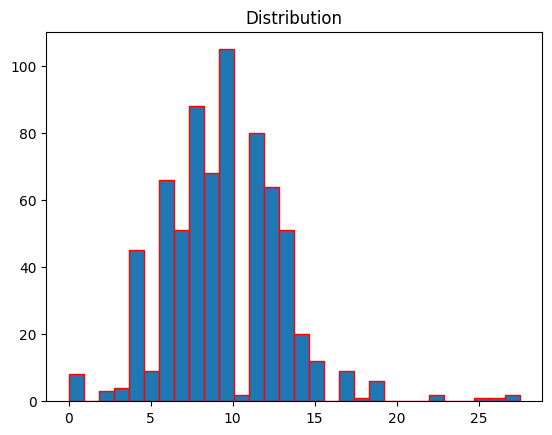

Time Series number: 2 
Mean: 5.714126074498568 , Var: 3.9276402681570217


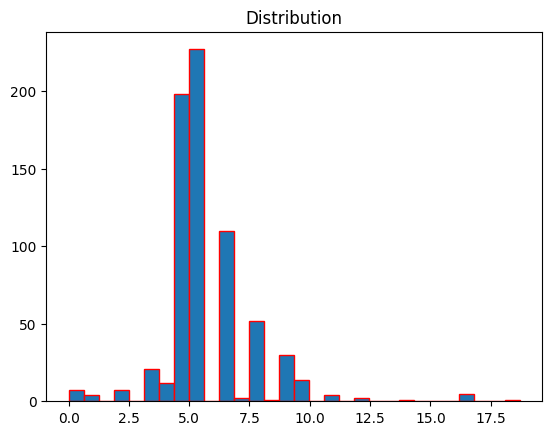

Time Series number: 3 
Mean: 7.3001547277936965 , Var: 6.6179586905156365


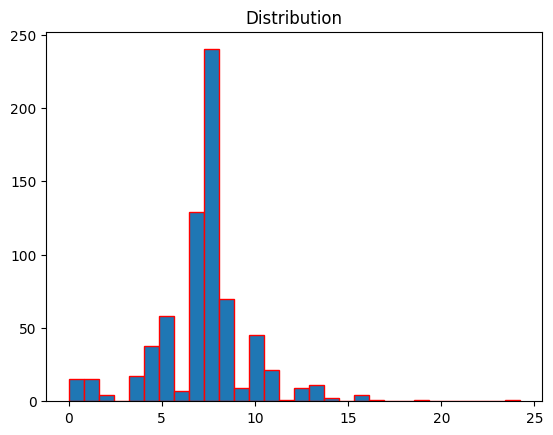

Time Series number: 4 
Mean: 7.919170487106017 , Var: 9.673989074192303


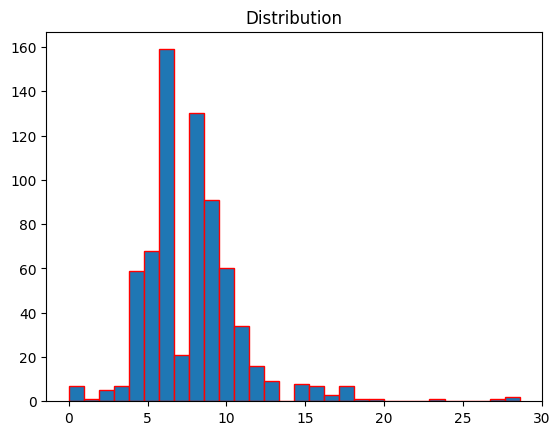

Time Series number: 5 
Mean: 9.34721776504298 , Var: 12.642878873600736


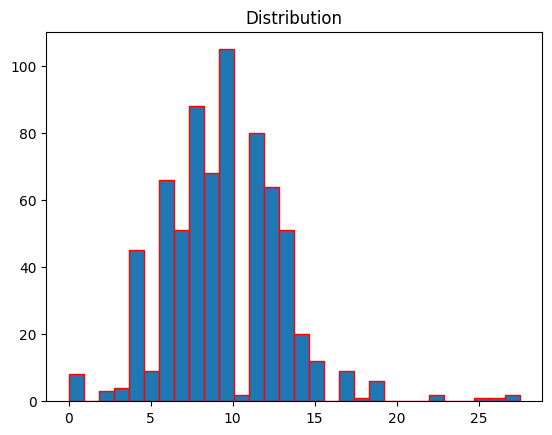

Time Series number: 6 
Mean: 4.22483094555874 , Var: 3.534816444837268


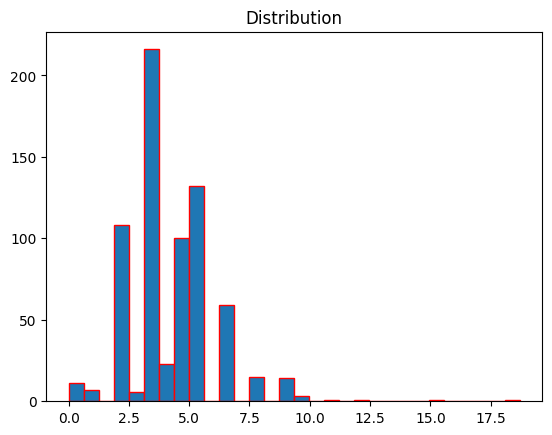

Time Series number: 7 
Mean: 5.498303724928367 , Var: 2.85975993057434


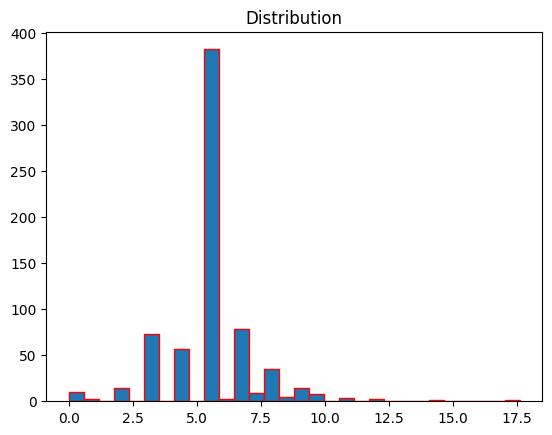

Time Series number: 8 
Mean: 6.473541547277938 , Var: 8.18168382395284


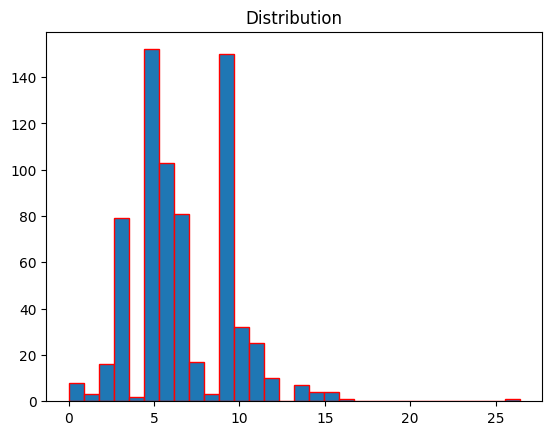

Time Series number: 9 
Mean: 4.22483094555874 , Var: 3.534816444837268


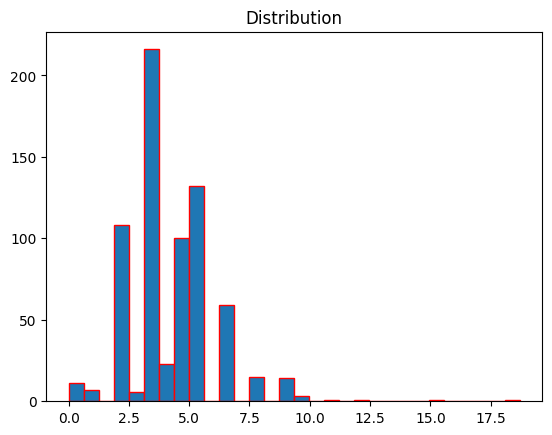

Time Series number: 10 
Mean: 3.609899713467049 , Var: 2.762493892367206


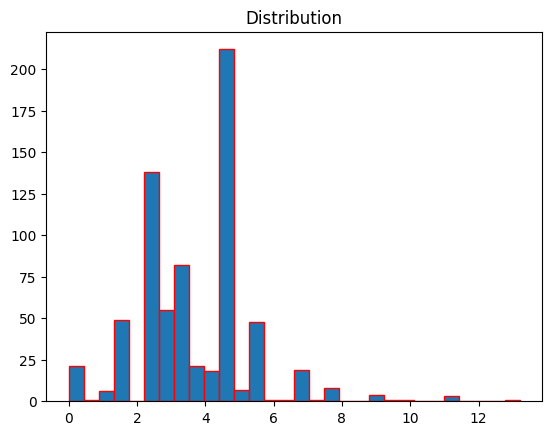

In [105]:
for i in range(len(all_Vol)):
    plot_and_mean_var(all_Vol[i][0], i+1)

### ${\color{pink}{Plot:}}$

In [106]:
def plot_time_series(time_series):
    plt.figure(figsize=(10, 5))
    plt.plot(time_series, color="b")
    # plt.plot(time_series, label=f"Seasonally Differenced (s={s})", color="b")
    # plt.legend()
    plt.grid(True)
    plt.title("Time Series")
    plt.show()

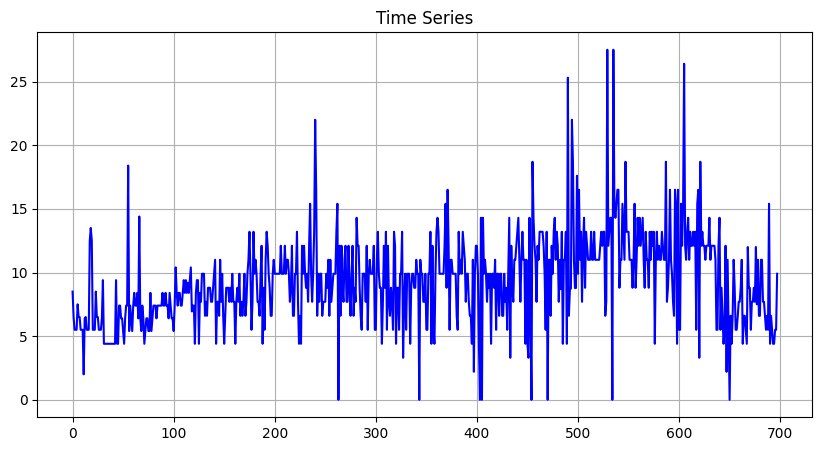

In [107]:
plot_time_series(x1)

### ${\color{pink}{Dot-Plot}}$

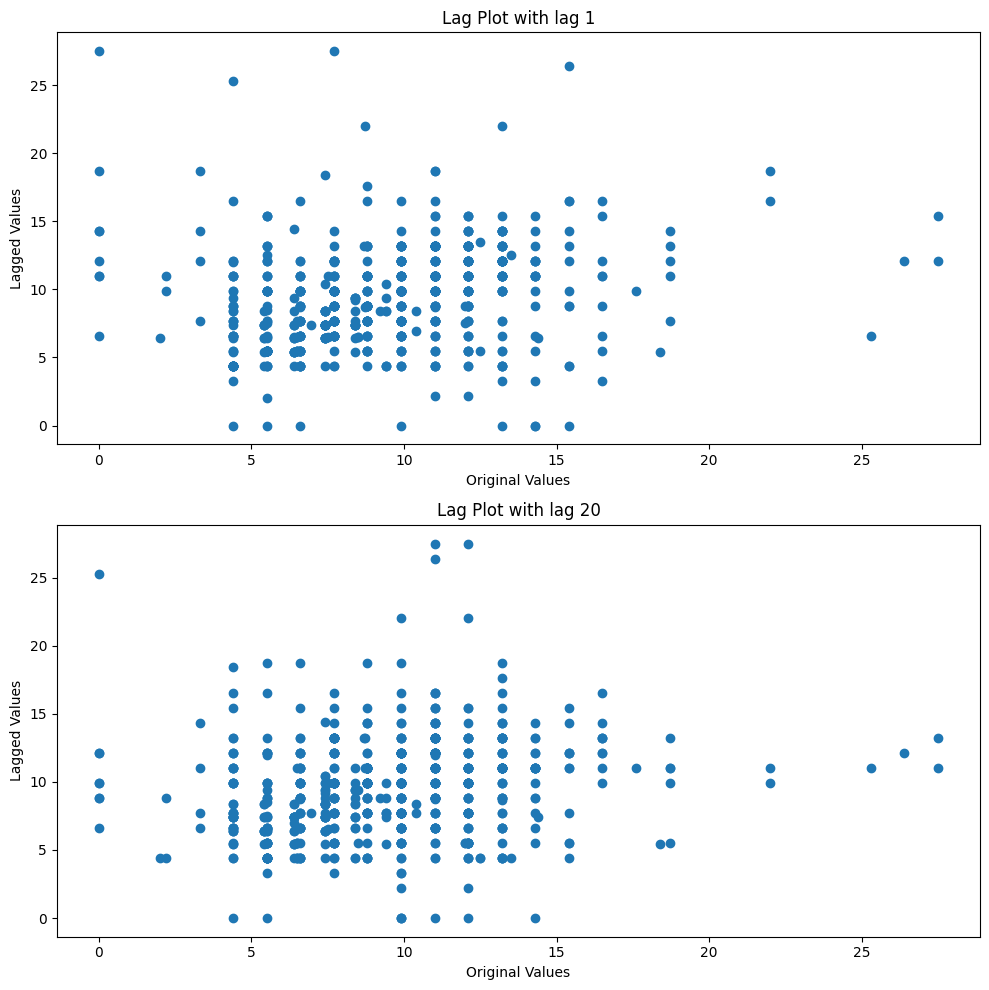

In [322]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

x1_series = pd.Series(x1)

# Create the lag plot on the specified Axes
lag_plot(x1_series, lag=1, ax=axes[0])


axes[0].set_title("Lag Plot with lag 1")
axes[0].set_xlabel("Original Values")
axes[0].set_ylabel("Lagged Values")


# Create the lag plot!
lag_plot(x1_series, lag=20, ax=axes[1])


axes[1].set_title("Lag Plot with lag 20")
axes[1].set_xlabel("Original Values")
axes[1].set_ylabel("Lagged Values")


plt.tight_layout()
plt.show()

### ${\color{pink}{ACF-PACF}}$

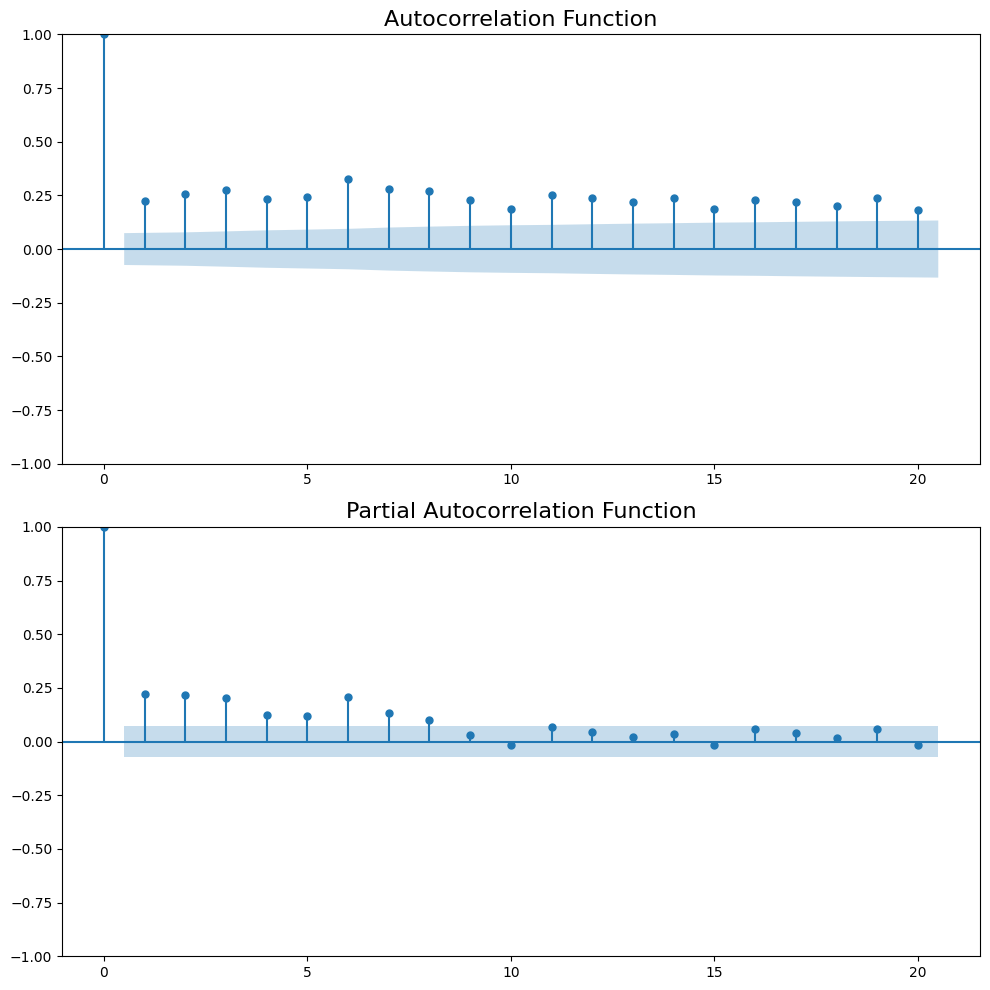

In [109]:
# Plot ACF and PACF

fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # Bigger plots (width=15, height=10)

plot_acf(x1, ax=axes[0], lags=20)
axes[0].set_title("Autocorrelation Function", fontsize=16)

plot_pacf(x1, ax=axes[1], lags=20, method="ywm")
axes[1].set_title("Partial Autocorrelation Function", fontsize=16)

plt.tight_layout()
plt.show()

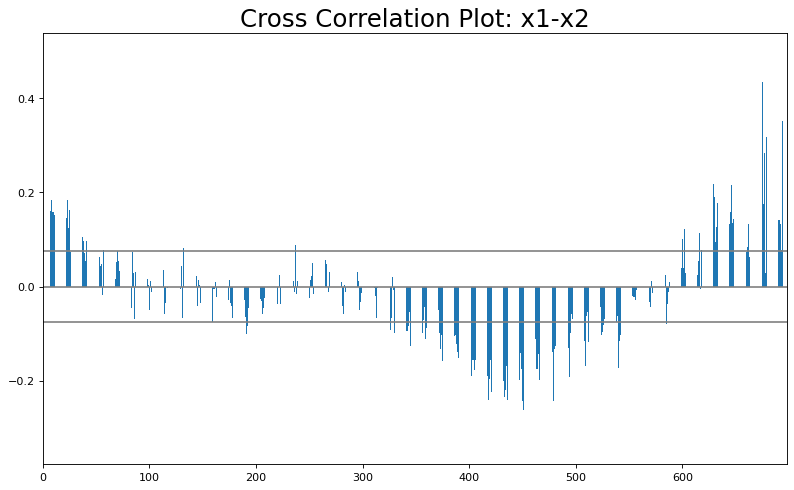

In [368]:
import statsmodels.tsa.stattools as stattools


ccs = stattools.ccf(x1, x2)
nlags = len(ccs)

conf_level = 2 / np.sqrt(nlags)

# Draw Plot
plt.figure(figsize=(12,7), dpi= 80)

#lines for easier visualization:
plt.hlines(0, xmin=0, xmax=len(x1), color='gray')  # 0 axis     
plt.hlines(conf_level, xmin=0, xmax=len(x1), color='gray')
plt.hlines(-conf_level, xmin=0, xmax=len(x1), color='gray')

plt.bar(x=np.arange(len(ccs)), height=ccs, width=.3)

# Decoration
plt.title('Cross Correlation Plot: x1-x2', fontsize=22)
plt.xlim(0,len(ccs))
plt.show()

### ${\color{pink}{Periodogram}}$

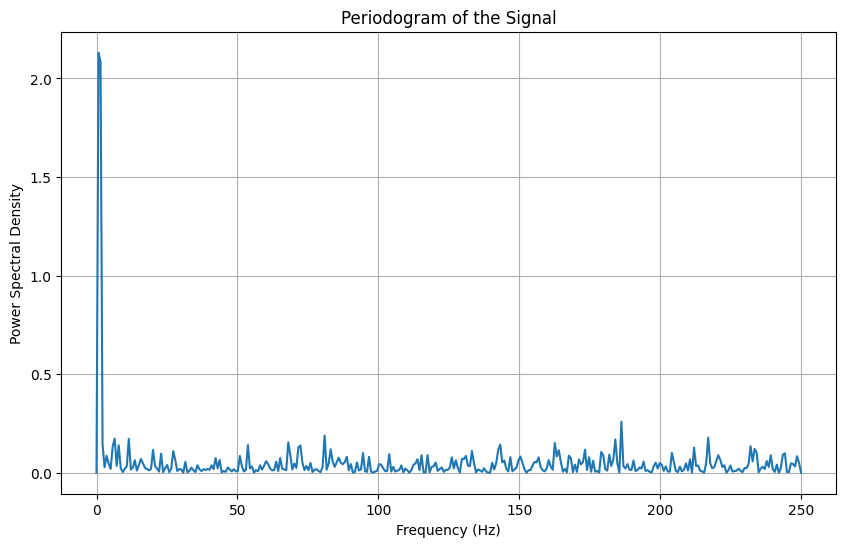

In [110]:
# Generate a sample signal
fs = 500  # Sampling frequency in Hz
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second of data
f1, f2 = 50, 150  # Frequencies of the components in Hz
signal = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t)


# Add some noise to the signal
noise = np.random.normal(0, 0.2, t.shape)
noisy_signal = signal + noise

# Compute the periodogram
frequencies, power = periodogram(x1, fs)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power)
plt.title("Periodogram of the Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.grid()
plt.show()

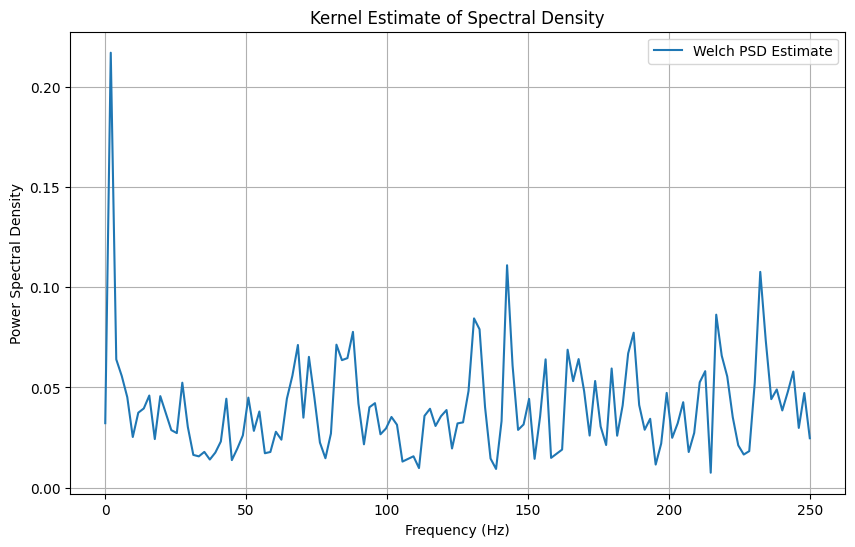

In [111]:
# Compute the spectral density using Welch's method
frequencies, power = welch(x1, fs, window='hamming', nperseg=256, noverlap=128)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power, label="Welch PSD Estimate")
plt.title("Kernel Estimate of Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.grid()
plt.legend()
plt.show()

----------------

# Stationary Analysis

For a process $X_t$ to be weakly stationary we need 3 conditions:
1) $\mathbb{E}[X_t] = \mu$
2) $\mathbb{VAR}[X_t] < \inf$
3) $\gamma_X(t,s)=\gamma_X(t+r,s+r)$

# Ways to make the process stationary

In [112]:
def make_stationary_integrated1(time_series):
    return np.diff(time_series)  # First difference


def make_stationary_integrated_d(time_series, d):
    dif = time_series
    for i in range(d):
        dif = np.diff(time_series)
    return dif


def make_stationary_seasonal(time_series, s=30):
    return time_series[s:] - time_series[:-s]

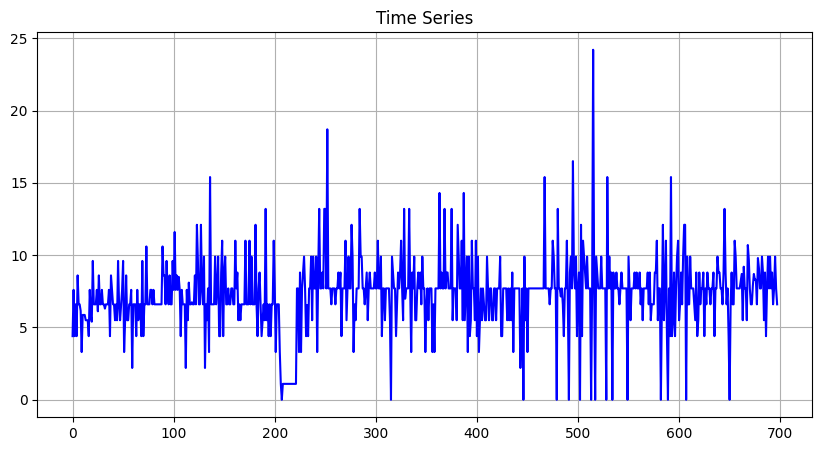

In [113]:
plot_time_series(x3)

----------------

# Ways to make the process stationary

# The Dickey–Fuller Test

In [114]:
from statsmodels.tsa.stattools import adfuller


def adf_test(time_series):
    adf_test = adfuller(time_series, regression='c')
    # print(f"ADF Statistic: {adf_test[0]}")
    # print(f"p-value: {adf_test[1]}")
    # print("Critical Values:", adf_test[4])  # 1%, 5%, and 10% confidence levels

    if adf_test[1] < 0.01:
        print("The series is likely stationary (reject H₀), according to dickey-fuller\n")
    else:
        print("The series is likely non-stationary (fail to reject H₀), according to dickey-fuller\n")

# KPSS test
(Kwiatkowski–Phillips–Schmidt–Shin)

In [115]:
from statsmodels.tsa.stattools import kpss


def kpss_test(time_series):
    kpss_test = kpss(time_series, regression="c", nlags="auto")
    # print(f"KPSS Statistic: {kpss_test[0]}")
    # print(f"p-value: {kpss_test[1]}")
    # print("Critical Values:", kpss_test[3])

    if kpss_test[1] < 0.05:
        print("The series is likely non-stationary (reject H₀), according to kpss\n")
    else:
        print("The series is likely stationary (fail to reject H₀), according to kpss\n")

# Rolling Statistics

In [116]:
def plot_rolling_statistics(time_series, window=50):
    # makes the input is a pandas Series
    time_series = pd.Series(time_series)

    rolling_mean = time_series.rolling(window=window).mean()  # calculating the std & mean for every 50 samples.
    rolling_std = time_series.rolling(window=window).std()

    plt.figure(figsize=(10, 5))
    plt.plot(time_series, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std Dev')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

In [117]:
def make_stationary_integrated1(time_series):
    return np.diff(time_series)  # First difference


def make_stationary_integrated_d(time_series, d):
    dif = time_series
    for i in range(d):
        dif = np.diff(time_series)
    return dif


def make_stationary_seasonal(time_series, s=7):
    return time_series[s:] - time_series[:-s]

# The original time series

The series is likely non-stationary (reject H₀), according to kpss

The series is likely stationary (reject H₀), according to dickey-fuller



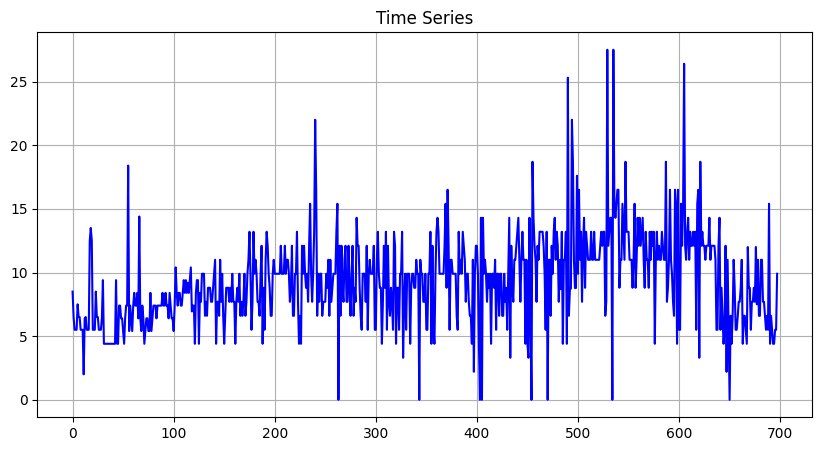

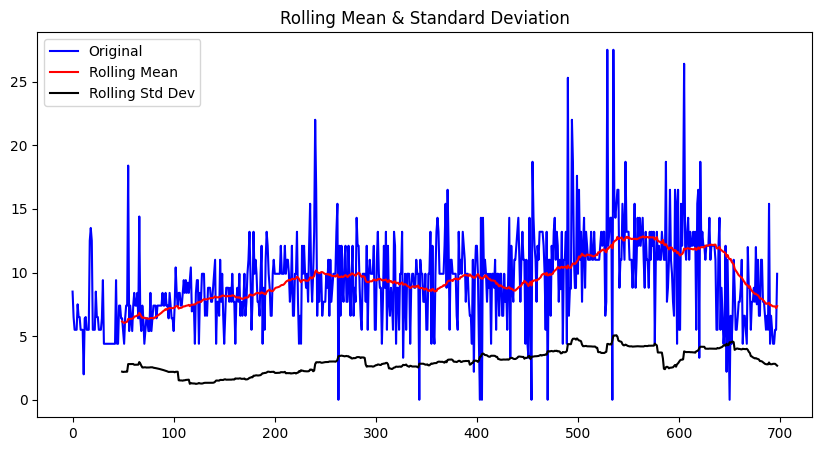

In [118]:
kpss_test(x1)
adf_test(x1)
plot_time_series(x1)
plot_rolling_statistics(x1)

#### As we can see, it isn't stationary

## Integrated of order 1

The series is likely stationary (fail to reject H₀), according to kpss

The series is likely stationary (reject H₀), according to dickey-fuller



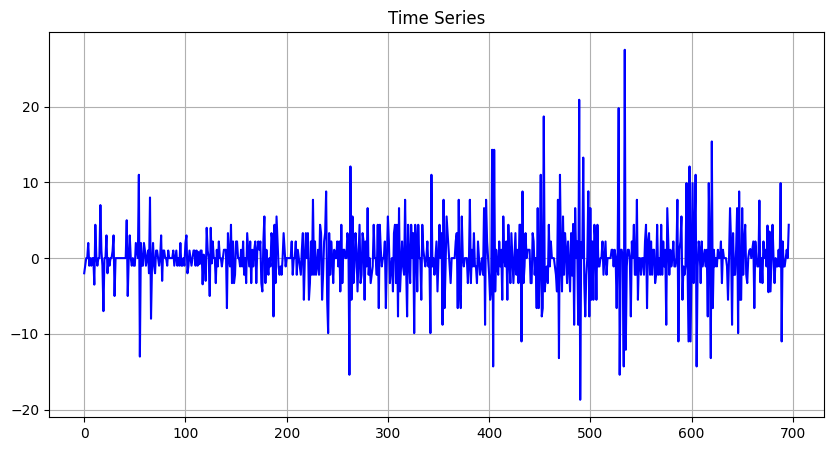

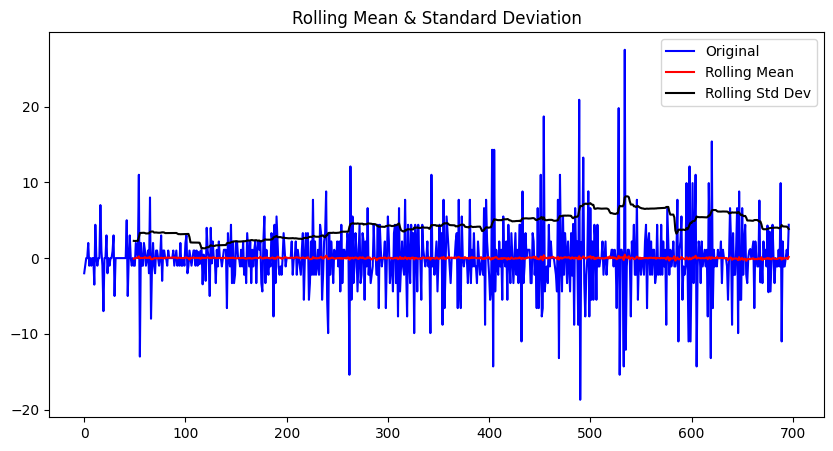

In [119]:
x1_integrated_order1 = make_stationary_integrated1(x1)
kpss_test(x1_integrated_order1)
adf_test(x1_integrated_order1)
plot_time_series(x1_integrated_order1)
plot_rolling_statistics(x1_integrated_order1)

## Integrated of order 2

The series is likely stationary (fail to reject H₀), according to kpss

The series is likely stationary (reject H₀), according to dickey-fuller



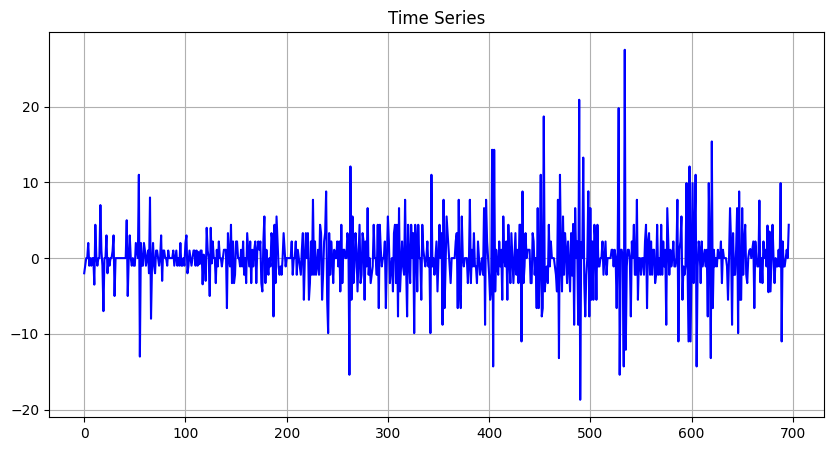

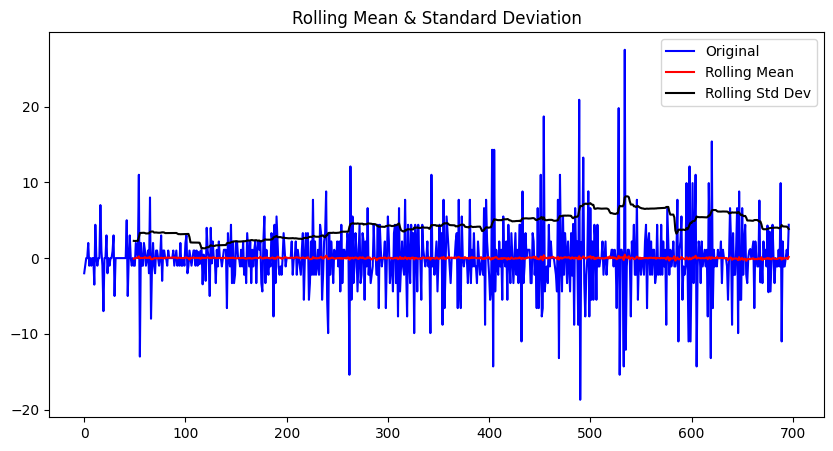

In [120]:
x1_integrated_order2 = make_stationary_integrated_d(x1, 2)
kpss_test(x1_integrated_order2)
adf_test(x1_integrated_order2)
plot_time_series(x1_integrated_order2)
plot_rolling_statistics(x1_integrated_order2)

## Seasonal of order 7

The series is likely stationary (fail to reject H₀), according to kpss

The series is likely stationary (reject H₀), according to dickey-fuller



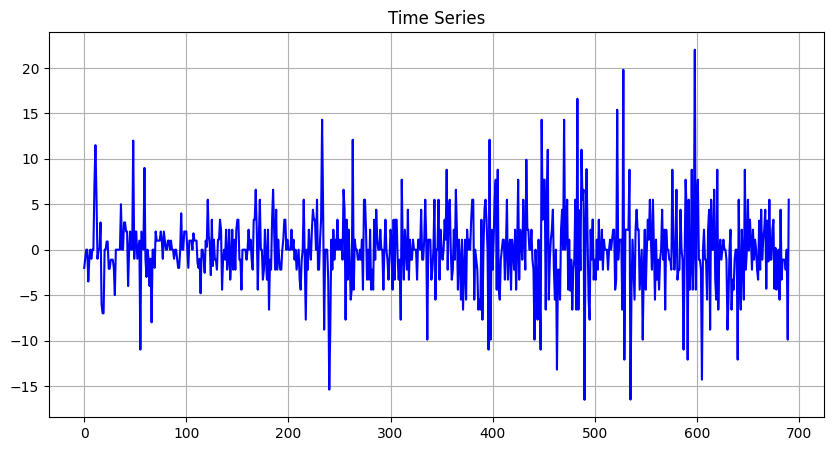

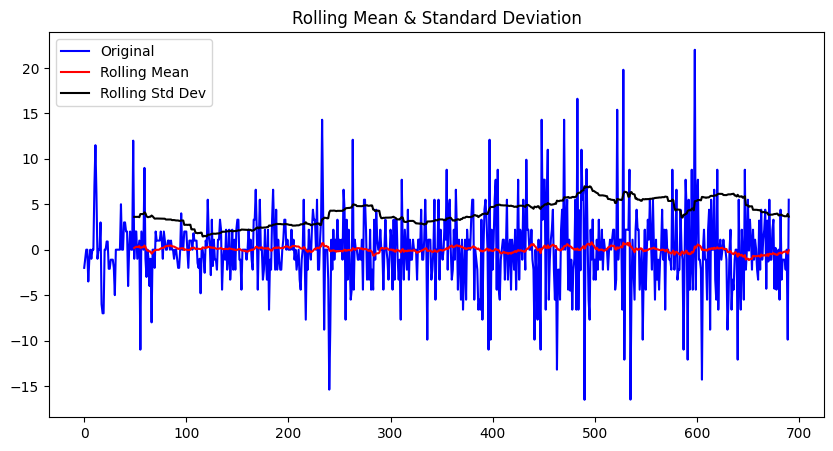

In [121]:
x1_seasonal_7 = make_stationary_seasonal(x1, 7)  # 30 for a season of a month
kpss_test(x1_seasonal_7)
adf_test(x1_seasonal_7)
plot_time_series(x1_seasonal_7)
plot_rolling_statistics(x1_seasonal_7)

## Seasonal of order 30

The series is likely stationary (fail to reject H₀), according to kpss

The series is likely stationary (reject H₀), according to dickey-fuller



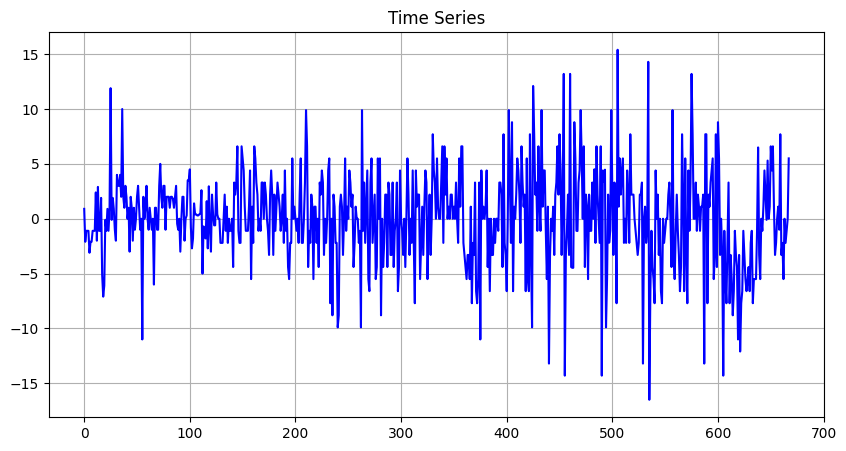

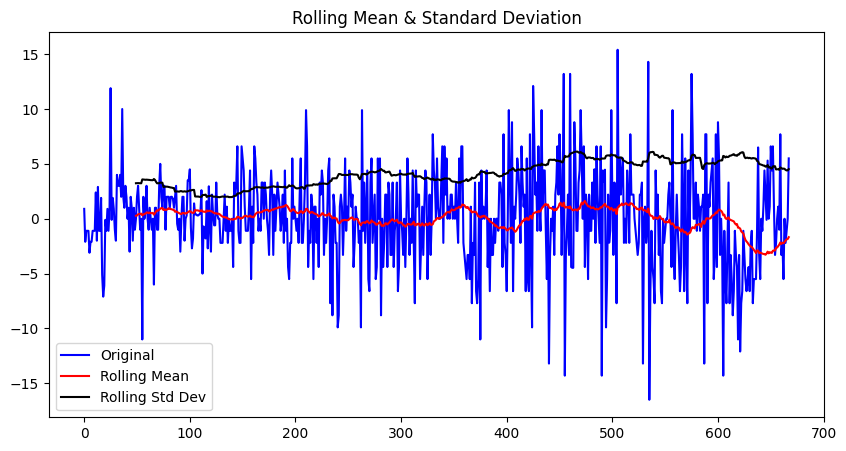

In [122]:
x1_seasonal_30 = make_stationary_seasonal(x1, 30)  # 30 for a season of a month
kpss_test(x1_seasonal_30)
adf_test(x1_seasonal_30)
plot_time_series(x1_seasonal_30)
plot_rolling_statistics(x1_seasonal_30)

# We want to check of $x_1$ is trend stationary

Augmented Dickey-Fuller unit root test.

In [123]:
def unit_root_test_Augmented_DF(time_series):
    adf_result_ct = adfuller(time_series, regression="ct")

    if adf_result_ct[1] <= 0.05:
        print("The null hypothesis of non-stationarity is rejected. The series is trend stationary.")
    else:
        print("The null hypothesis of non-stationarity cannot be rejected. The series trend is non-stationary.")

In [124]:
unit_root_test_Augmented_DF(x1)

The null hypothesis of non-stationarity is rejected. The series is trend stationary.


In [363]:
def apply_linear_time_trend_to_graph(time_series,regressor=0): # trying to match a reggresion between the garbage and temperture.
    import statsmodels.api as sm
    if regressor==0:
        regressor=np.arange(len(time_series))
    regressor = sm.add_constant(regressor)
    model = sm.OLS(time_series, regressor).fit()
    
    # Extract the trend
    trend = model.predict(regressor)
    print(f"The slope is {np.round(model.params[1],4)} and the interceptis {np.round(model.params[0],4)} ")
    # Detrend the time series
    return time_series - trend,np.round(model.params[1],4),np.round(model.params[0],4)

# Example of it working

The slope is 0.7932 and the interceptis 5.1198 


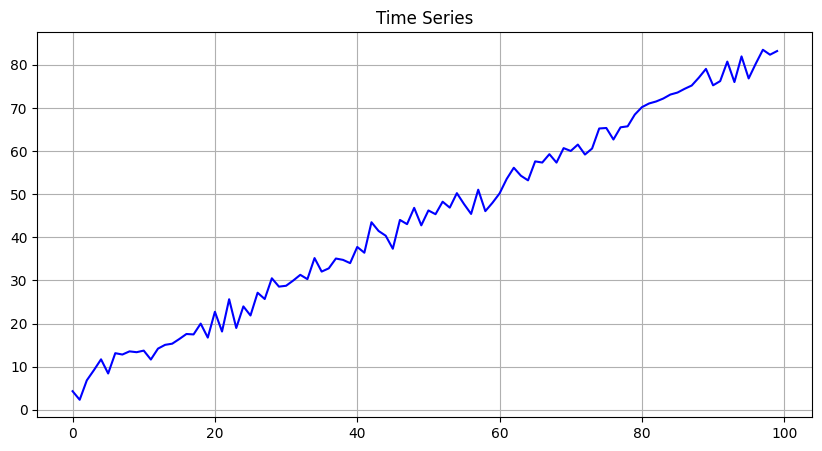

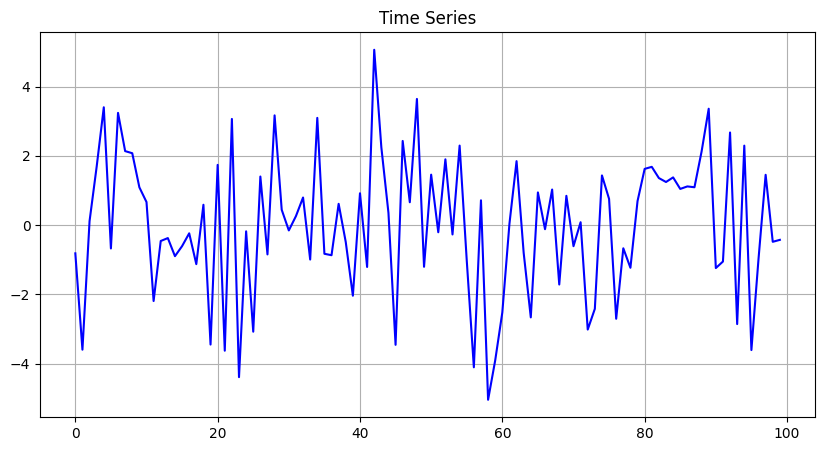

In [364]:
n = 100
time_series = 5 + 0.8 * np.arange(n) + np.random.normal(scale=2, size=n)
time_series_no_trend,*_=apply_linear_time_trend_to_graph(time_series)
plot_time_series(time_series)
plot_time_series(time_series_no_trend)

As seen before, x1 is not stationary
The series is likely stationary (reject H₀), according to dickey-fuller

The series is likely non-stationary (reject H₀), according to kpss

The slope is 0.0055 and the interceptis 7.4274 

The series is likely stationary (reject H₀), according to dickey-fuller

The series is likely stationary (fail to reject H₀), according to kpss



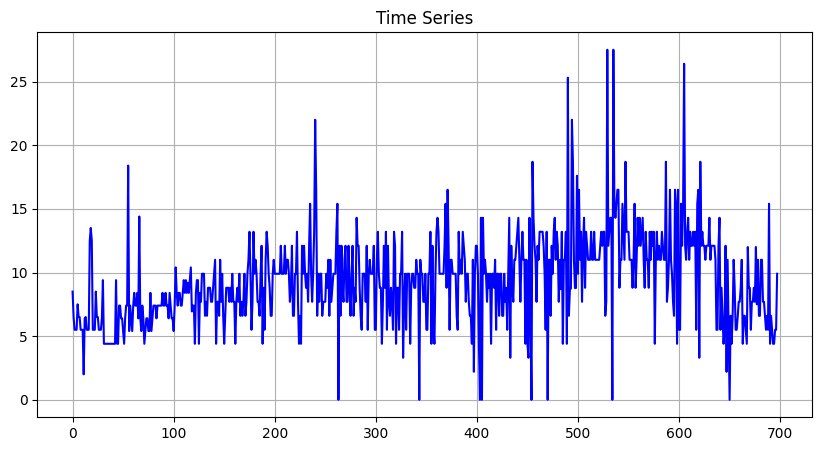

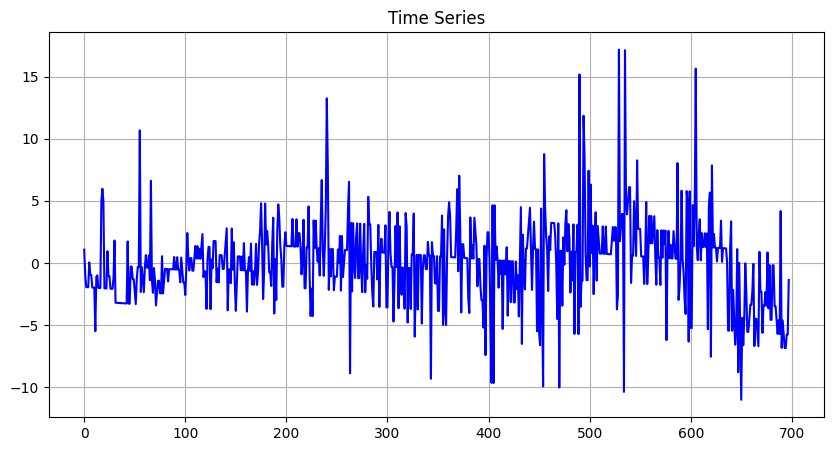

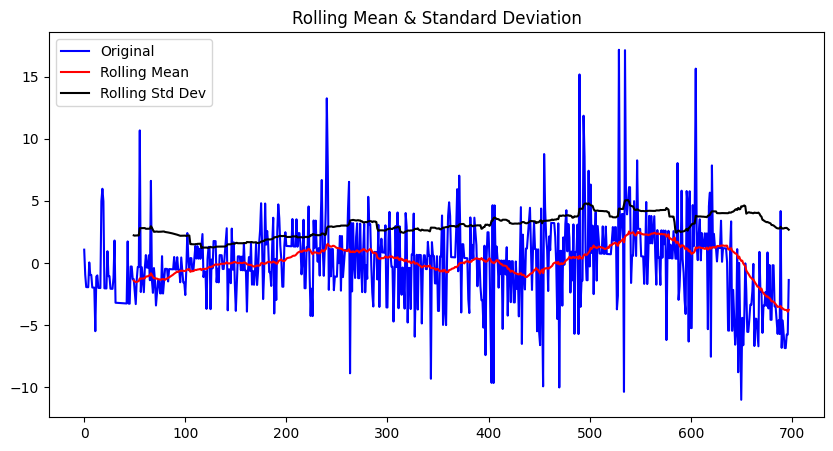

In [365]:
print("As seen before, x1 is not stationary")
adf_test(x1)
kpss_test(x1)
x1_trend_removed,time_slope,time_intercept=apply_linear_time_trend_to_graph(x1)
print("")
adf_test(x1_trend_removed)
kpss_test(x1_trend_removed)
plot_time_series(x1)
plot_time_series(x1_trend_removed)
plot_rolling_statistics(x1_trend_removed)

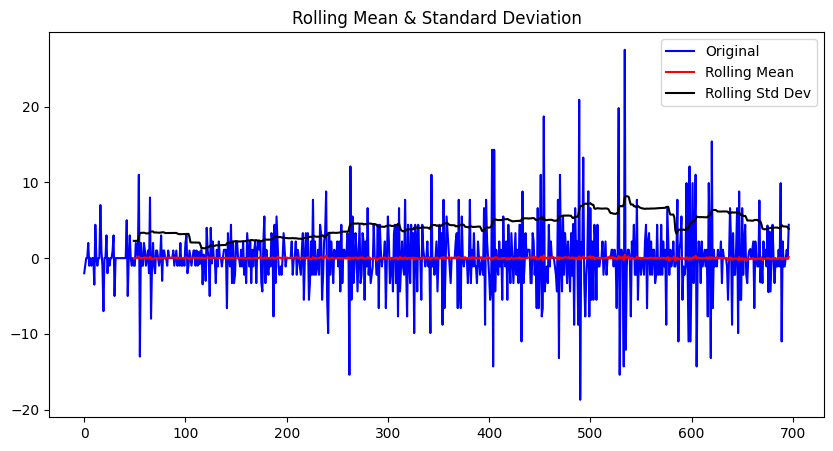

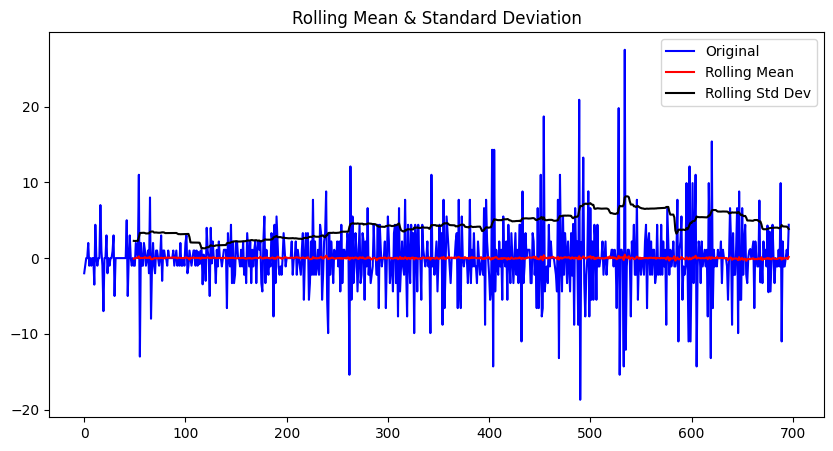

In [128]:
x1_trend_removed_integrated1 = make_stationary_integrated1(x1_trend_removed)
plot_rolling_statistics(x1_trend_removed_integrated1)
plot_rolling_statistics(x1_integrated_order1)

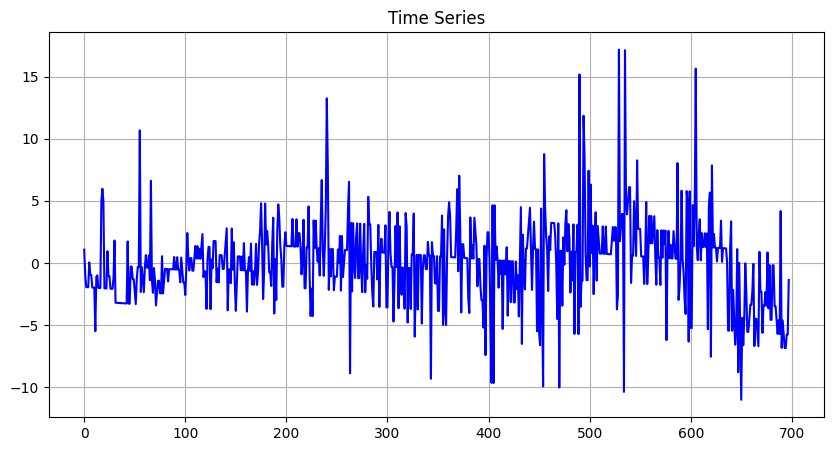

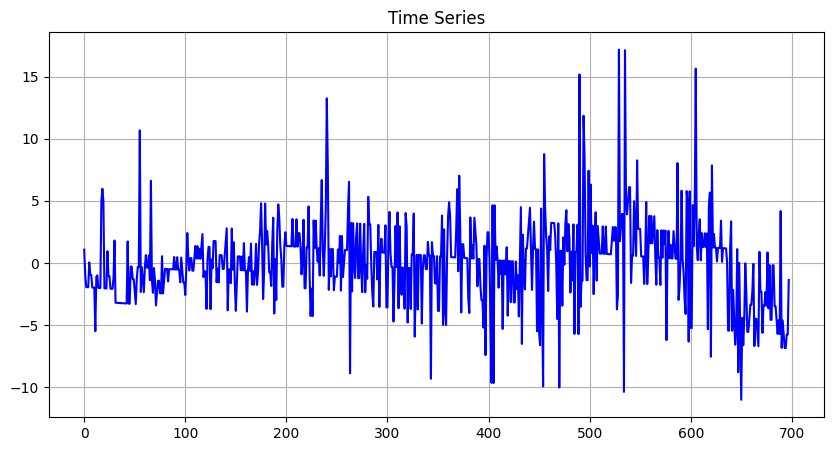

In [129]:
from statsmodels.tsa.tsatools import detrend
detrended_series = detrend(x1, order=1)  # Removes linear trend
plot_time_series(detrended_series)
plot_time_series(x1_trend_removed)

### We got
The best series are ranked from up to bottom

In [130]:
x1_integrated_order1
x1_integrated_order2
x1_seasonal_7
x1_trend_removed_integrated1
x1_trend_removed
x1_seasonal_30

array([  0.9  ,  -2.1  ,  -1.1  ,  -1.1  ,  -1.1  ,  -3.1  ,  -2.1  ,
        -2.1  ,  -1.1  ,  -1.1  ,  -1.1  ,   2.4  ,  -2.   ,   2.9  ,
        -1.1  ,  -1.1  ,   1.9  ,  -5.1  ,  -7.1  ,  -6.1  ,  -0.1  ,
        -1.1  ,   0.9  ,  -1.1  ,   0.9  ,  11.9  ,  -0.1  ,   1.9  ,
         0.9  ,  -1.   ,  -2.   ,   4.   ,   3.   ,   3.   ,   4.   ,
         2.   ,  10.   ,   2.   ,   1.   ,   3.   ,   2.   ,   0.   ,
         1.   ,  -3.   ,   2.   ,   1.   ,  -2.   ,   1.   ,  -1.   ,
         0.   ,   2.   ,   3.   ,   1.   ,  -1.   ,   0.   , -11.   ,
         2.   ,   0.   ,   1.   ,   3.   ,   0.   ,  -1.   ,   1.   ,
         0.   ,  -1.   ,   0.   ,  -6.   ,   1.   ,   1.   ,  -1.   ,
        -1.   ,   3.   ,   5.   ,   2.   ,   1.   ,   3.   ,   3.   ,
        -1.   ,   2.   ,   2.   ,   2.   ,   1.   ,   2.   ,   2.   ,
         1.8  ,   1.   ,   2.   ,   3.   ,  -0.457,  -1.   ,   0.   ,
        -3.   ,   0.   ,   2.   ,   2.   ,  -2.   ,   0.   ,   0.3  ,
         3.5  ,   3.

## In addition, we want to use our temperture data as well.

In [131]:
final_tempreture = np.array(Final_Temperature)
final_tempreture.shape
x1.shape

(698,)

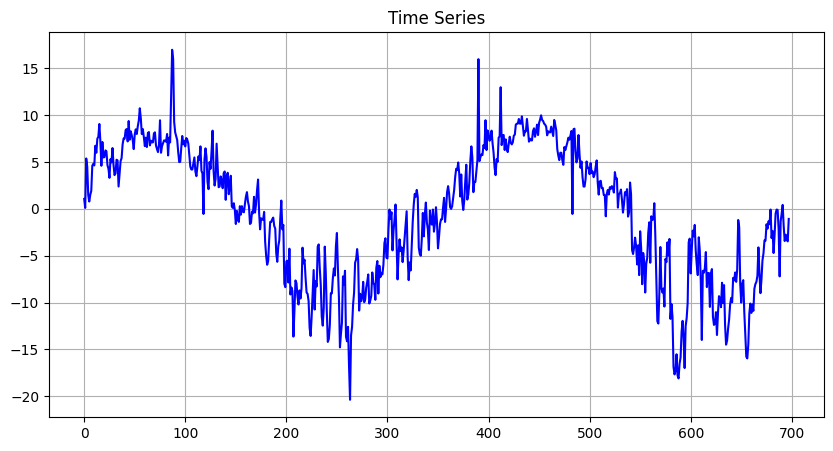

In [132]:
plot_time_series(final_tempreture)

### As we can see, the tempreture is not stationary

The series is likely stationary (fail to reject H₀), according to kpss

The series is likely stationary (reject H₀), according to dickey-fuller



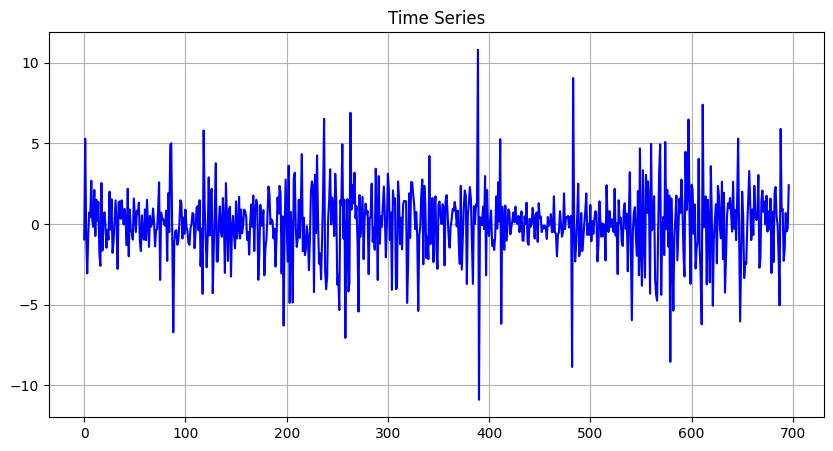

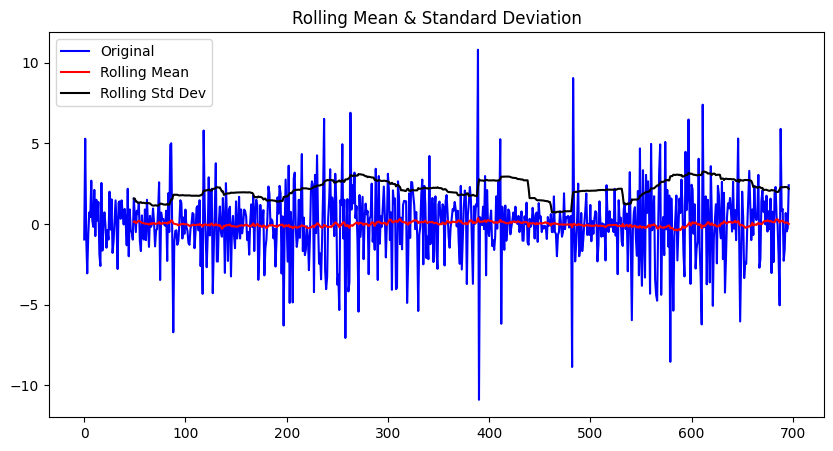

In [133]:
temperature_integrated_order1 = make_stationary_integrated1(final_tempreture)
kpss_test(temperature_integrated_order1)
adf_test(temperature_integrated_order1)
plot_time_series(temperature_integrated_order1)
plot_rolling_statistics(temperature_integrated_order1)

## As we can see, $x_1$ and the temperture are both integrated of order 1.
#### So we will try to do co integration, if they are cointegrated, the regression should produce 
#### integrated of order 0 process.

### Now we will want to check if they are cointegrated.

### We need to check if it is stationary
We need to use the unit root test, but with DF. Phillips- Ouliaris Distribution. \
We need to do that, because the unlike regular DF, this version checks when we do cointegration, \
while the regular DF checks for a single time series. 
$$
y_t = \alpha + \beta x_t + \eta  _t
$$
Like in the regular DF, do the unit root test, we calculate the residuals

## DF. Phillips- Ouliaris Test

In [134]:
from arch.unitroot.cointegration import phillips_ouliaris


def phillips_ouliaris_test_common_trend(first_time_series, second_time_series):
    phillips_ouliaris_test = phillips_ouliaris(first_time_series, second_time_series)
    if phillips_ouliaris_test.pvalue < 0.05:
        print("The two series likely share a common trend \n")
    else:
        print("The two series are not likely to share a common trend \n")

## Engle-Granger Test, similar to DF. Phillips- Ouliaris

$H_0:$  no cointegration

In [135]:
from statsmodels.tsa.stattools import coint


def Engle_Granger_Test(first_time_series, second_time_series):
    Engle_Granger_Test = coint(first_time_series, second_time_series, trend='ct',)
    if Engle_Granger_Test[1] < 0.05:
        print("The two series likely share a common trend \n")
    else:
        print("The two series are not likely to share a common trend \n")

In [136]:
phillips_ouliaris_test_common_trend(x1, final_tempreture)
Engle_Granger_Test(x1, final_tempreture)

The two series likely share a common trend 

The two series likely share a common trend 



### Now, after we know they have a common trend, lets calculate the time series.

In [352]:
def apply_temprature_regressor_to_graph(time_series,temprature): # trying to match a reggresion between the garbage and temperture.
    slope, intercept,*_ = stats.linregress(temprature, time_series)
    return time_series-(slope*temprature+intercept),slope,intercept

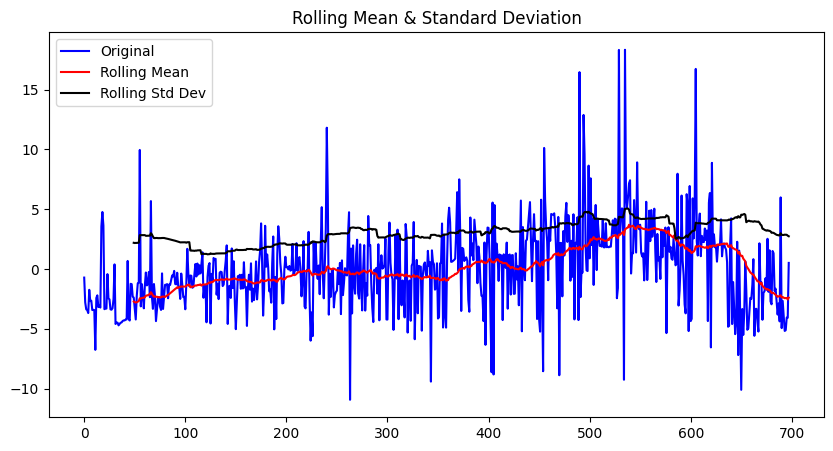

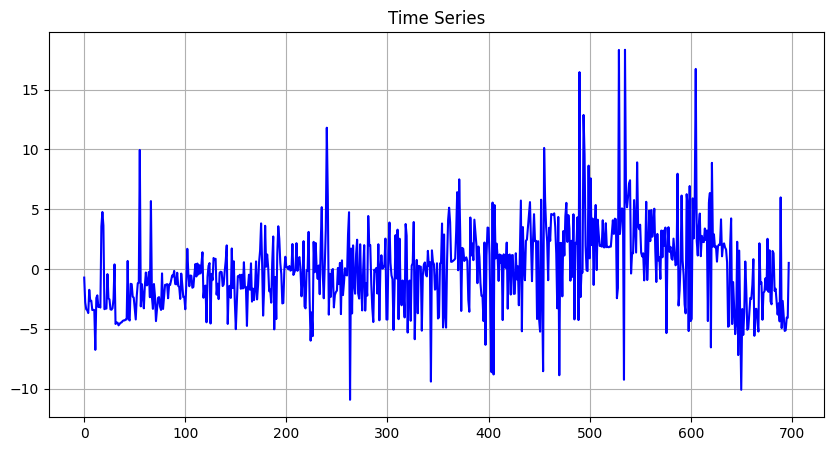

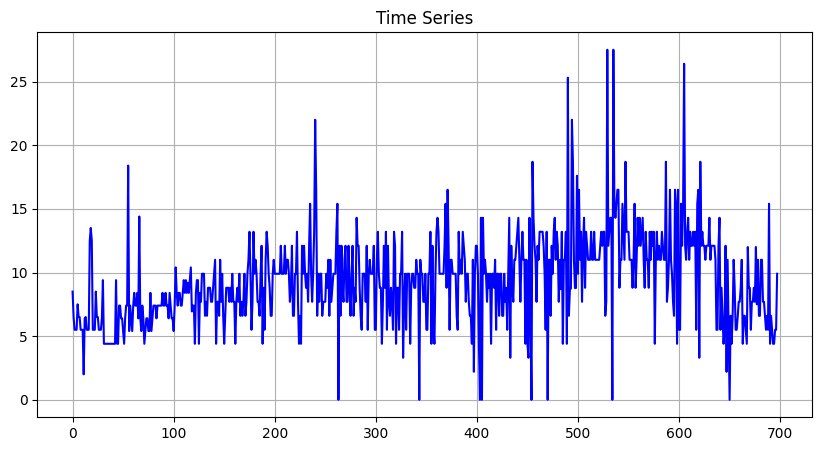

In [353]:
x1_temperture_reduced,tempreture_slope,temperture_intercept=apply_temprature_regressor_to_graph(x1,final_tempreture)
plot_rolling_statistics(x1_temperture_reduced)
plot_time_series(x1_temperture_reduced)
plot_time_series(x1)

The series is likely stationary (fail to reject H₀), according to kpss

The series is likely stationary (reject H₀), according to dickey-fuller



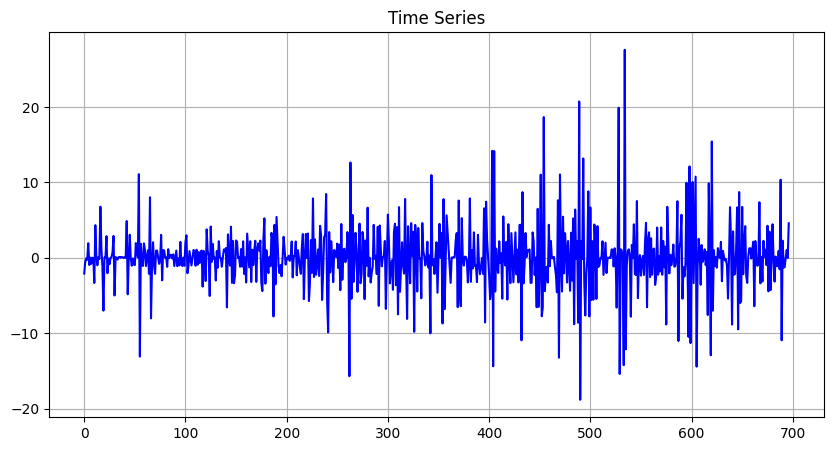

In [360]:
x1_temperture_reduced_integrated1=make_stationary_integrated1(x1_temperture_reduced)
kpss_test(x1_temperture_reduced_integrated1)
adf_test(x1_temperture_reduced_integrated1)
plot_time_series(x1_temperture_reduced_integrated1)

In [140]:
x1_temperture_reduced_integrated1 = make_stationary_integrated1(x1_temperture_reduced)

In [ ]:
x1_integrated_order1
x1_integrated_order2
x1_seasonal_7
x1_trend_removed_integrated1
x1_temperture_reduced
x1_trend_removed
x1_temperture_reduced_integrated1 
pass

# inverse functions

In [366]:
def inverse_regressor(time_series,slope,intercept,regressor=np.array([])):
    if regressor.shape[0]==0:
        regressor=np.arange(len(time_series))
    return time_series+(slope*regressor+intercept) 

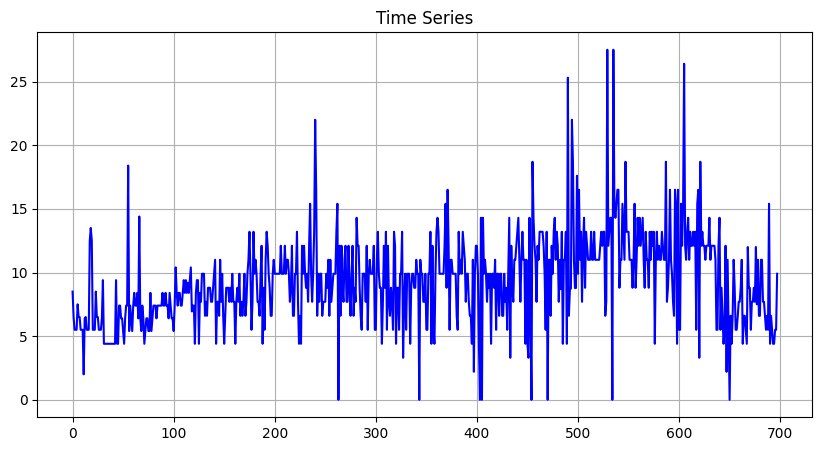

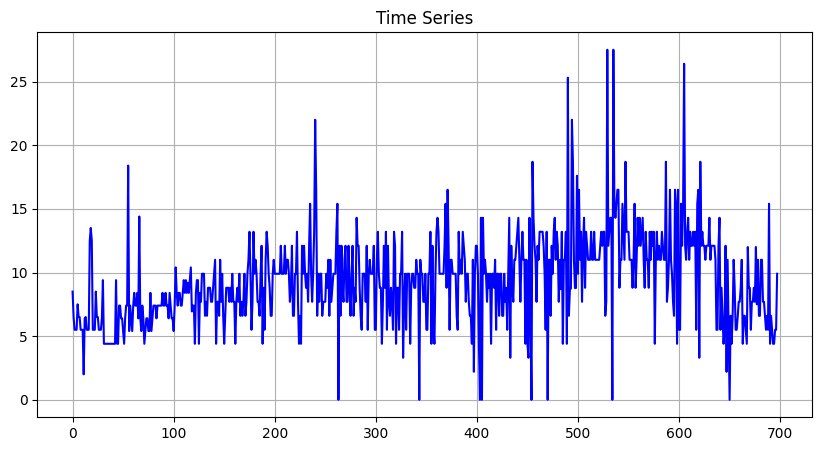

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [372]:
plot_time_series(inverse_regressor(x1_temperture_reduced,tempreture_slope,temperture_intercept,final_tempreture))
plot_time_series(x1)
print(np.round(x1-inverse_regressor(x1_temperture_reduced,tempreture_slope,temperture_intercept,final_tempreture)),4)

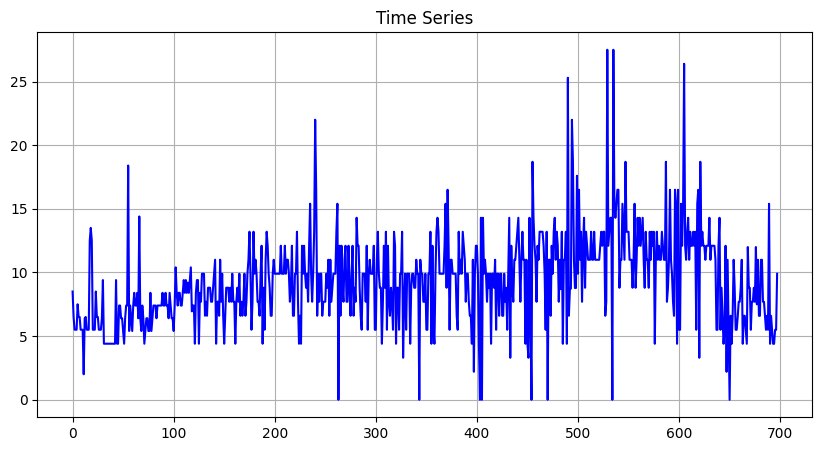

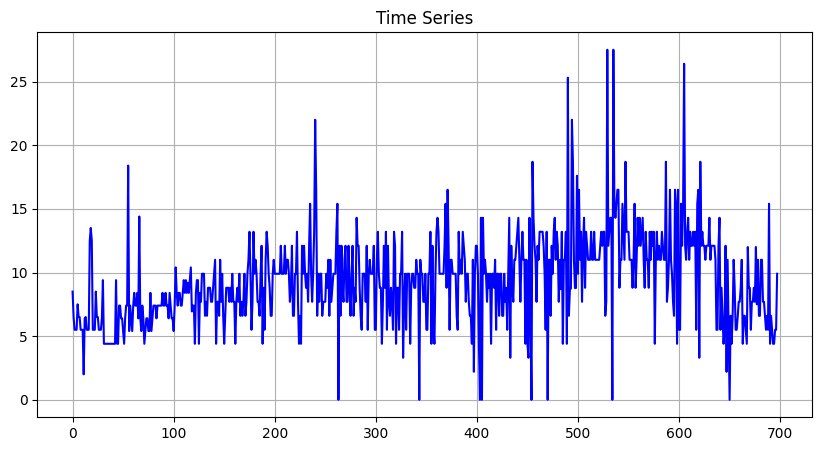

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [371]:
plot_time_series(inverse_regressor(x1_trend_removed,time_slope,time_intercept))
plot_time_series(x1)
print(np.round(x1-inverse_regressor(x1_trend_removed,time_slope,time_intercept)),4)


---

# Standard ARMA models


In [142]:
def plot_acf_pacf(data, lags=100):
    _, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(data, lags=100, ax=axes[0], title="Autocorrelation, finding MA(q)")  # MA terms
    plot_pacf(data, lags=100, ax=axes[1], title="Autocorrelation, finding AR(p)")  # AR terms
    plt.show()

In [143]:
def estimate_arma_by_test(data, start_p=0, end_p=7, start_q=0, end_q=7, tests=('aic')):
    values = {test: {} for test in tests}

    for p in tqdm(range(start_p, end_p)):
        for q in range(start_q, end_q):
            model = ARIMA(data, order=(p, 0, q))
            result = model.fit(method_kwargs={"warn_convergence": False})
            for test in tests:
                values[test][(p, q)] = getattr(result, test)

    best_orders = {}
    for test in tests:
        best_order = min(values[test], key=values[test].get)
        best_orders[test] = {"p": best_order[0], "q": best_order[1], "score": values[test][best_order], "overall_values": values[test]}
        print(f"Best order based on {test}: {best_order} with {test}: {values[test][best_order]}")

    return best_orders


def decide_arma_based_on_estimator(estimators):
    freq = {}
    for value in estimators.values():
        pair = (value['p'], value['q'])
        freq[pair] = freq.get(pair, 0) + 1

    lowest_error = min(estimators.values(), key=lambda x: x['score']) if max(freq.values()) > 1 else None
    most_common_occurrence = max(freq, key=freq.get)

    return {"lowest_error": ((lowest_error["p"], lowest_error["q"]), lowest_error["score"]), "highest_occurrence": most_common_occurrence}

In [327]:
def calculate_loss(data, model_data):
    return ((data - model_data) ** 2).sum() / data.shape[0]

In [145]:
def calculate_arma_parameters(data, start_p=0, max_p=10, start_q=0, max_q=10):
    model = pm.auto_arima(data, start_p=start_p, max_p=max_p, start_q=start_q, max_q=max_q, d=0, seasonal=False)
    print(model.summary())
    return model


calculate_arma_parameters(x1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  698
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -1790.537
Date:                Wed, 19 Feb 2025   AIC                           3591.075
Time:                        11:22:58   BIC                           3613.816
Sample:                             0   HQIC                          3599.867
                                - 698                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0790      0.065      1.223      0.221      -0.048       0.206
ar.L1          0.9910      0.007    149.771      0.000       0.978       1.004
ma.L1         -0.9872      0.027    -36.930      0.0

ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True)

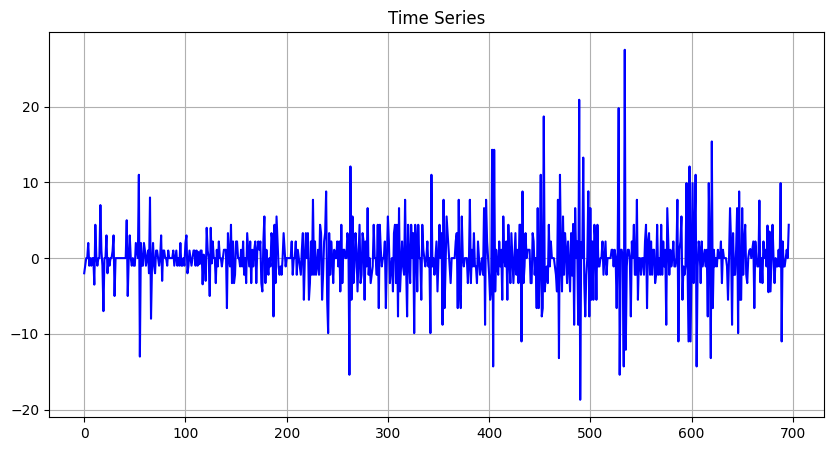

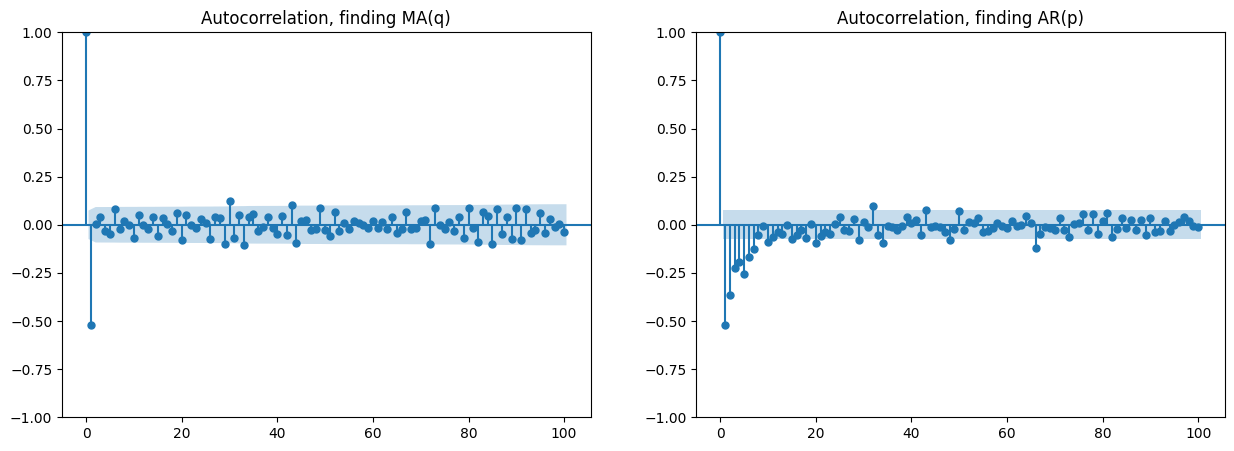

100%|██████████| 7/7 [00:37<00:00,  5.38s/it]


Best order based on aic: (4, 6) with aic: 3584.7550841577176
Best order based on bic: (0, 1) with bic: 3602.0409928107647
Best order based on hqic: (0, 1) with hqic: 3593.6744814916447
{'lowest_error': ((4, 6), 3584.7550841577176), 'highest_occurrence': (0, 1)}
model based on auto arima with data:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  697
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1789.791
Date:                Wed, 19 Feb 2025   AIC                           3585.582
Time:                        11:23:37   BIC                           3599.222
Sample:                             0   HQIC                          3590.856
                                - 697                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025   

In [146]:
def find_best_model_for_given_data(data):
    # first, plot the data
    plot_time_series(data)

    # next we want to look at ACF/PACF graphs
    plot_acf_pacf(data)
    # from the ACF graph we shall extract MA parameters,
    # and from the PACF graph we will get the AR parameters

    # now lets look at some test
    estimators = estimate_arma_by_test(data, tests=('aic', 'bic', 'hqic'))
    best_estimators = decide_arma_based_on_estimator(estimators)
    print(best_estimators)

    # on original data:
    model = pm.auto_arima(data, start_p=0, max_p=50, start_q=0, max_q=50, d=0, seasonal=False)
    print("model based on auto arima with data:")
    print(model.summary())


# we see that for x1 integrated of order 1 the ACF cuts off after lag 2, and AR gradually decays, thus we estimate MA(2) model
find_best_model_for_given_data(x1_integrated_order1)

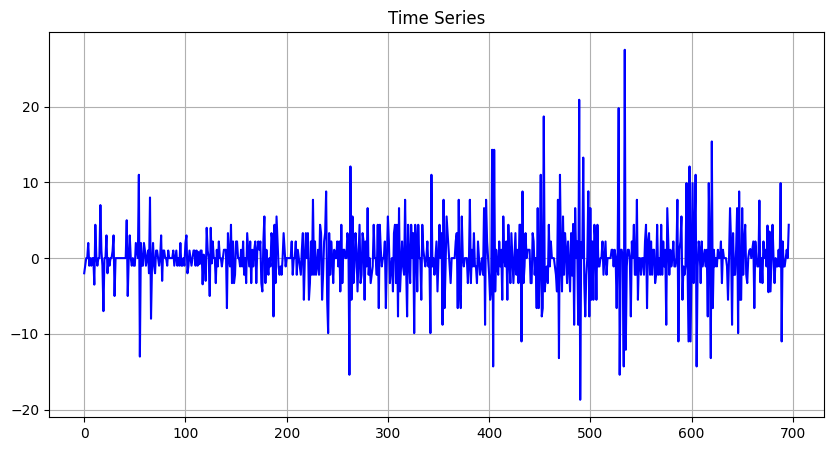

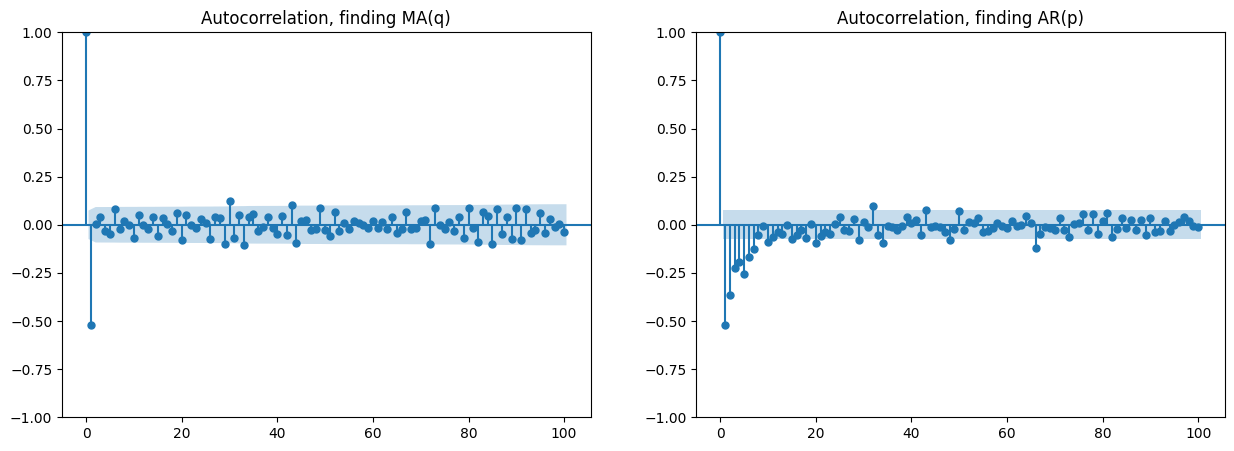

100%|██████████| 7/7 [00:37<00:00,  5.32s/it]


Best order based on aic: (4, 6) with aic: 3584.7550841577176
Best order based on bic: (0, 1) with bic: 3602.0409928107647
Best order based on hqic: (0, 1) with hqic: 3593.6744814916447
{'lowest_error': ((4, 6), 3584.7550841577176), 'highest_occurrence': (0, 1)}
model based on auto arima with data:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  697
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1789.791
Date:                Wed, 19 Feb 2025   AIC                           3585.582
Time:                        11:24:15   BIC                           3599.222
Sample:                             0   HQIC                          3590.856
                                - 697                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025   

In [147]:
# lets looks at some more models.
# we see that for x1 integrated of order 2 the ACF cuts off after lag 2, and AR gradually decays, thus we estimate MA(2) model
find_best_model_for_given_data(x1_integrated_order2)

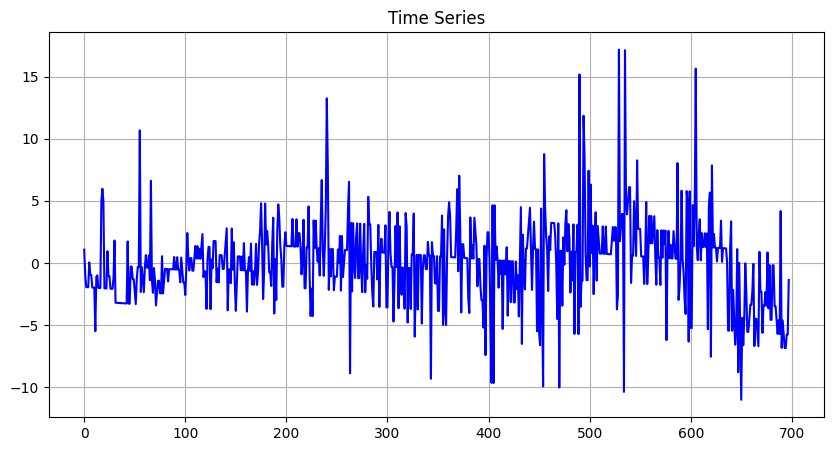

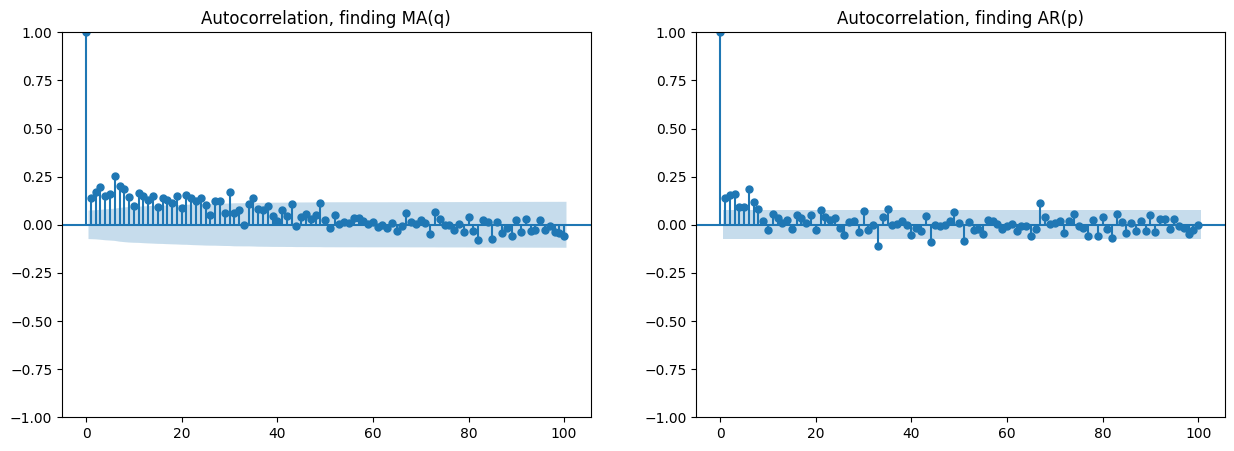

100%|██████████| 7/7 [00:36<00:00,  5.25s/it]


Best order based on aic: (5, 6) with aic: 3586.9393797031357
Best order based on bic: (1, 1) with bic: 3609.930931164133
Best order based on hqic: (1, 1) with hqic: 3598.7715997128407
{'lowest_error': ((5, 6), 3586.9393797031357), 'highest_occurrence': (1, 1)}
model based on auto arima with data:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  698
Model:               SARIMAX(6, 0, 1)   Log Likelihood               -1786.631
Date:                Wed, 19 Feb 2025   AIC                           3589.262
Time:                        11:24:59   BIC                           3625.647
Sample:                             0   HQIC                          3603.329
                                - 698                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025    

In [148]:
# we see that for x1 integrated of order 2 the ACF cuts off after lag 2, and AR gradually decays, thus we estimate MA(2) model
find_best_model_for_given_data(x1_trend_removed)

In [149]:
def plot_integrated_predictions(data, predicted_data):
    plt.figure(figsize=(10, 5))

    pred = np.hstack((np.zeros(data.shape), predicted_data))
    plt.plot(data, color="b")
    plt.plot(pred, color="r")
    plt.grid(True)
    plt.title("Time Series")
    plt.show()

the model's summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   97
Model:                 ARIMA(6, 0, 1)   Log Likelihood                -252.525
Date:                Wed, 19 Feb 2025   AIC                            523.050
Time:                        13:37:46   BIC                            546.223
Sample:                             0   HQIC                           532.420
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0748      0.069     -1.091      0.275      -0.209       0.060
ar.L1         -0.5796      0.275     -2.105      0.035      -1.119      -0.040
ar.L2         -0.5159      0.24

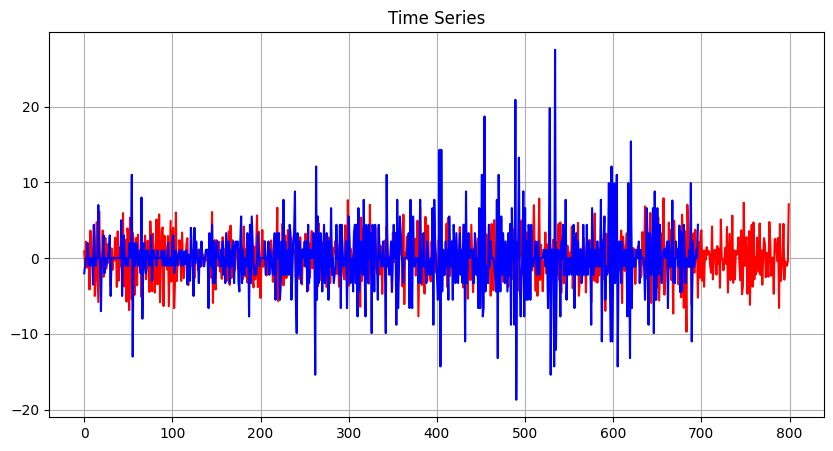

In [328]:
def train_arma_model(data, p, q):
    split = int(0.8 * data.shape[0])
    train = data[:split]
    test = data[split:]
    model = ARIMA(data[600:], order=(p, 0, q))
    model_fit = model.fit()
    # Print the model summary
    print("the model's summary:")
    print(model_fit.summary())

    test_arma = model_fit.predict(split + 1, data.shape[0])
    print("model's error across 20% validation set:", calculate_loss(test, test_arma))

    # plot_integrated_predictions(data, test_arma)
    plt.figure(figsize=(10, 5))

    # pred = np.hstack([data, model_fit.predict(start=data[600:].shape[0], end=data[600:].shape[0] + 100)])
    pred = np.hstack(arma_generate_sample(model._polynomial_ar, model._polynomial_ma, nsample=800, scale=2))
    plt.plot(pred, color="r")
    plt.plot(data, color="b")
    plt.grid(True)
    plt.title("Time Series")
    plt.show()


# train_arma_model(x1_trend_removed, 6, 1)
train_arma_model(x1_integrated_order1, 6, 1)

# Testing GARCH models

In [151]:
def find_arch(data):
    dict_aic = {}

    for l in range(5):
        for p in range(1, 5):
            for q in range(1, 5):
                try:
                    split_date = data[-1]
                    model = arch_model(data, mean='ARX', lags=l, vol='Garch', p=p, o=0, q=q, dist='Normal')
                    res = model.fit(last_obs=split_date)
                    dict_aic[(l, p, q)] = res.aic
                except:
                    pass

    df_aic = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])
    l, p, q = df_aic[df_aic.aic == df_aic.aic.min()].index[0]
    print(f'ARIMA-GARCH order is ({l}, {p}, {q})')
find_arch(x1_integrated_order1)      # (4, 1, 4)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2695.5381362749804
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2419.8913101245016
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1961.1448977517744
Iteration:      4,   Func. Count:     24,   Neg. LLF: 2187.4363690280497
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1937.5015638445398
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1924.9327688362287
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1924.8482201920285
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1924.8419212239273
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1924.8375339273182
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1924.8374929793608
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1924.8374924536497
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1924.8374924536497
            Iterations: 11
            Function evaluations: 61
            Gradient eva

In [152]:
# def plot_garch(data, l, p, q):
#     model = arch_model(data, mean='ARX', lags=l, vol='Garch', p=p, o=0, q=q, dist='Normal')
#     res = model.fit(last_obs=data[-1])
#     plt.figure(figsize=(10, 5))

#     pred = res.forecast(horizon=5, start=data.shape[-1])
#     print(pred)
#     plt.plot(pred, color="r")
#     plt.plot(x1_integrated_order1, color="b")
#     plt.grid(True)
#     plt.title("Time Series")
#     plt.show()
# plot_garch(x1_integrated_order1, 4, 1, 4)

----

# Seasonal ARMA

## trend removed:

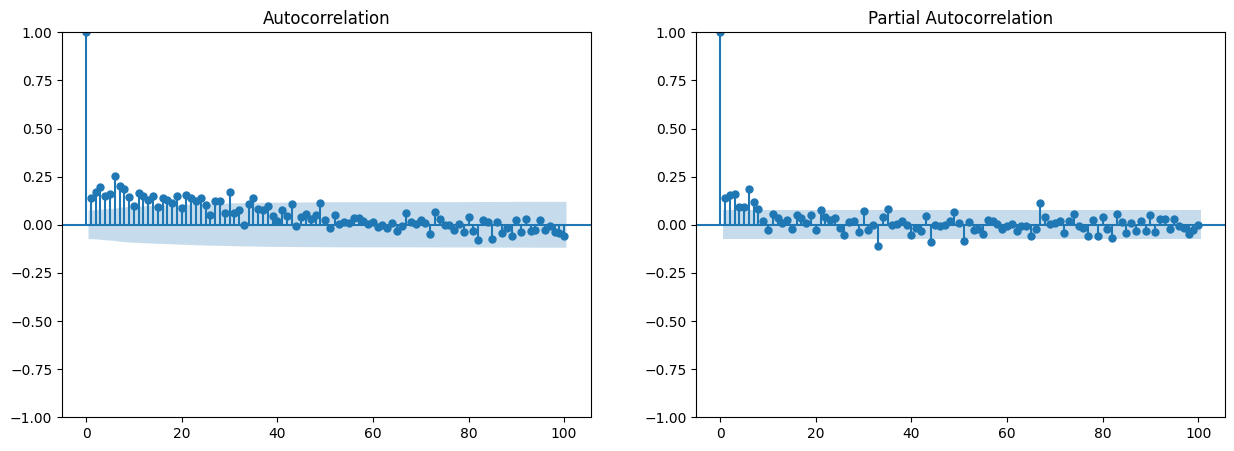

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(x1_trend_removed, lags=100, ax=axes[0])  # MA terms
plot_pacf(x1_trend_removed, lags=100, ax=axes[1])  # AR terms
plt.show()

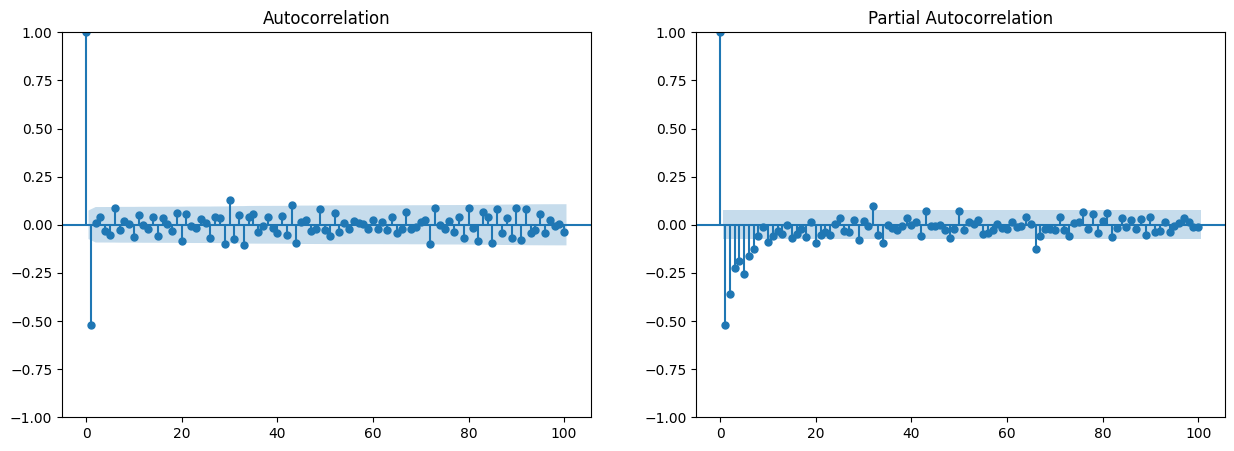

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(x1_temperture_reduced_integrated1, lags=100, ax=axes[0])  # MA terms
plot_pacf(x1_temperture_reduced_integrated1, lags=100, ax=axes[1])  # AR terms
plt.show()

## testing diffrent parameters

In [157]:
def estimate_sarma_by_test(data, start_p=0, end_p=3, start_q=0, end_q=3, tests=('aic', 'bic', 'hqic')):
    values = {test: {} for test in tests}
    # for p in tqdm(range(start_p,end_p-1)):
    for q in tqdm(range(start_q, end_q)):
        for p_s in range(start_p, end_p):
            for q_s in range(start_q, end_q):
                for s in range(3, 7, 3):
                    model = sarimax.SARIMAX(data, order=(0, 0, q), seasonal_order=(p_s, 0, q_s, s))
                    result = model.fit(method_kwargs={"warn_convergence": False})
                    for test in tests:
                        values[test][f"({0}, 0, {q})x({p_s}, 0, {q_s})_{s}"] = getattr(result, test)

    best_orders = {}
    for test in tests:
        best_order = min(values[test], key=values[test].get)
        # best_orders[test] = {"p": best_order[0], "q": best_order[1], "score": values[test][best_order], "overall_values": values[test]}
        print(f"Best order based on {test}: {best_order} with {test}: {values[test][best_order]}")

    return best_orders

In [267]:
estimate_sarma_by_test(x1_trend_removed[:600])  # (0, 0, 0)x(2, 0, 2)_3
pass

100%|██████████| 3/3 [00:09<00:00,  3.29s/it]

Best order based on aic: (0, 0, 0)x(1, 0, 1)_6 with aic: 3058.7620227633165
Best order based on bic: (0, 0, 0)x(1, 0, 1)_6 with bic: 3071.952811728965
Best order based on hqic: (0, 0, 0)x(1, 0, 1)_6 with hqic: 3063.896931566599


In [268]:
estimate_sarma_by_test(x1_integrated_order1[:600])  # (0, 0, 2)x(1, 0, 0)_6
pass

100%|██████████| 3/3 [00:12<00:00,  4.17s/it]

Best order based on aic: (0, 0, 2)x(1, 0, 1)_3 with aic: 3056.8600918531483
Best order based on bic: (0, 0, 1)x(0, 0, 0)_3 with bic: 3068.2779066966555
Best order based on hqic: (0, 0, 1)x(0, 0, 0)_3 with hqic: 3062.907319921745


In [269]:
estimate_sarma_by_test(x1_temperture_reduced[:600])  # (0, 0, 0)x(2, 0, 2)_3
pass

100%|██████████| 3/3 [00:11<00:00,  3.70s/it]

Best order based on aic: (0, 0, 0)x(2, 0, 2)_3 with aic: 3073.462180147028
Best order based on bic: (0, 0, 0)x(1, 0, 1)_3 with bic: 3086.76426526794
Best order based on hqic: (0, 0, 0)x(1, 0, 1)_3 with hqic: 3078.708385105574


## Accurate parameters, ok WN with temp

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  601
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 6)   Log Likelihood               -1565.849
Date:                            Wed, 19 Feb 2025   AIC                           3137.699
Time:                                    13:42:39   BIC                           3150.895
Sample:                                         0   HQIC                          3142.835
                                            - 601                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0596      0.033      1.793      0.073      -0.006       0.125
ar.S.L6        0.2543      0.029   

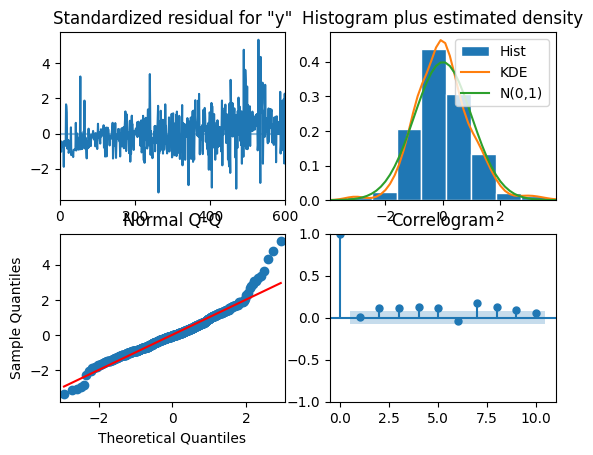

In [338]:
from statsmodels.tsa.statespace import sarimax


sarima_model_temp = sarimax.SARIMAX(x1_temperture_reduced[:601],
                                    order=(0, 0, 1),
                                    seasonal_order=(1, 0, 0, 6),
                                    mle_regression=True,
                                    enforce_stationarity=True,
                                    enforce_invertibility=True)

sarima_model_temp = sarima_model_temp.fit()
sarima_model_temp.plot_diagnostics()
print(sarima_model_temp.summary())

In [162]:
from arch import arch_model

residuals = sarima_model_temp.resid

# Fit GARCH(1,1) model on residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")  # Fit without printing verbose output

print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1786.84
Distribution:                  Normal   AIC:                           3581.68
Method:            Maximum Likelihood   BIC:                           3599.88
                                        No. Observations:                  698
Date:                Wed, Feb 19 2025   Df Residuals:                      697
Time:                        11:25:34   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.3957      0.135     -2.927  3.421e-03 [ -0.661, -0.13

## accurate parameters, ok WN without temp

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  601
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 3)   Log Likelihood               -1527.694
Date:                           Wed, 19 Feb 2025   AIC                           3065.388
Time:                                   14:21:13   BIC                           3087.381
Sample:                                        0   HQIC                          3073.949
                                           - 601                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0741      0.030     -2.443      0.015      -0.134      -0.015
ma.L1         -0.9430      0.014    -65.254

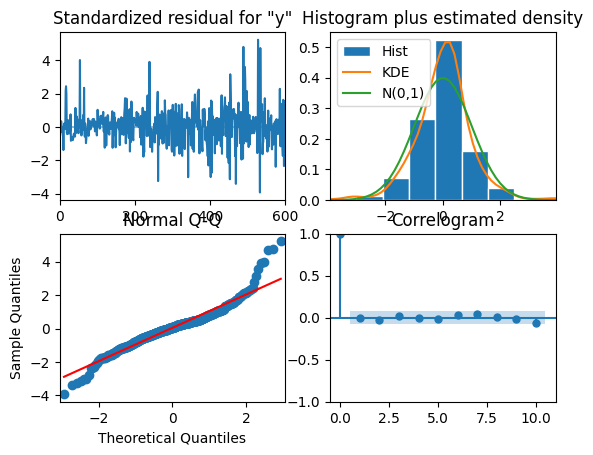

In [373]:
from statsmodels.tsa.statespace import sarimax

sarima_model_integrated = sarimax.SARIMAX(x1_integrated_order1[:601],
                                          order=(1, 0, 1),
                                          seasonal_order=(1, 0, 1, 3),
                                          mle_regression=True,
                                          enforce_stationarity=True,
                                          enforce_invertibility=True)

sarima_model_integrated = sarima_model_integrated.fit()
sarima_model_integrated.plot_diagnostics()
print(sarima_model_integrated.summary())

## Not accurate WN parameter, ok WN shape and AIC

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  601
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 3)   Log Likelihood               -1530.451
Date:                           Wed, 19 Feb 2025   AIC                           3068.902
Time:                                   13:42:44   BIC                           3086.496
Sample:                                        0   HQIC                          3075.750
                                           - 601                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0239      0.029     -0.812      0.417      -0.082       0.034
ar.S.L3        0.9487      0.036     26.021

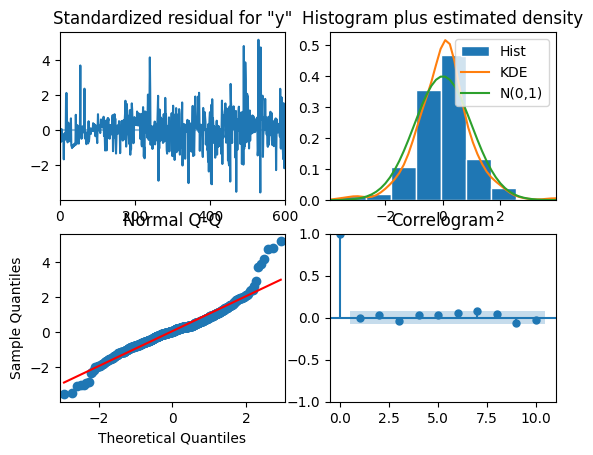

In [340]:
from statsmodels.tsa.statespace import sarimax


sarima_model_trend_remove_1 = sarimax.SARIMAX(x1_trend_removed[:601],
                                              order=(0, 0, 1),
                                              seasonal_order=(1, 0, 1, 3),
                                              mle_regression=True,
                                              enforce_stationarity=True,
                                              enforce_invertibility=True)

sarima_model_trend_remove_1 = sarima_model_trend_remove_1.fit()
sarima_model_trend_remove_1.plot_diagnostics()
print(sarima_model_trend_remove_1.summary())

## Accurate WN parameter, not so good WN shape worse AIC

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  601
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 6)   Log Likelihood               -1525.041
Date:                            Wed, 19 Feb 2025   AIC                           3058.081
Time:                                    14:22:46   BIC                           3075.676
Sample:                                         0   HQIC                          3064.930
                                            - 601                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9881      0.012     84.057      0.000       0.965       1.011
ma.L1         -0.9539      0.023   

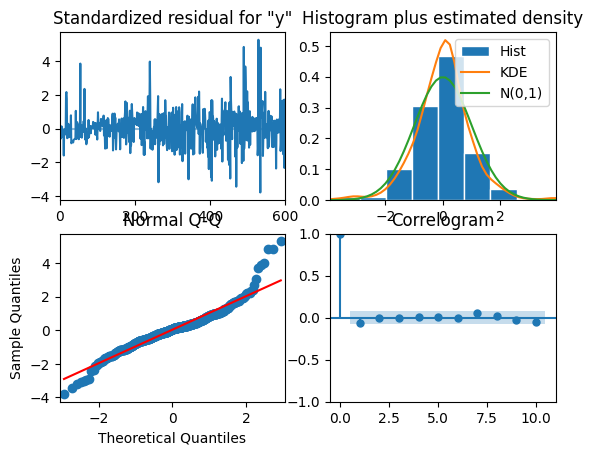

In [374]:
from statsmodels.tsa.statespace import sarimax


sarima_model_trend_remove_2 = sarimax.SARIMAX(x1_trend_removed[:601],
                                              order=(1, 0, 1),
                                              seasonal_order=(1, 0, 0, 6),
                                              mle_regression=True,
                                              enforce_stationarity=True,
                                              enforce_invertibility=True)

sarima_model_trend_remove_2 = sarima_model_trend_remove_2.fit()
sarima_model_trend_remove_2.plot_diagnostics()
print(sarima_model_trend_remove_2.summary())

# Testing With Forecast

In [ ]:
def plot_predictions_full(data, model, start=0, end=750):
    plt.figure(figsize=(10, 5))
    plt.plot(np.hstack((np.zeros(start), model.predict(start, end))), color="r")
    plt.plot(data, color="b")
    plt.grid(True)
    plt.title("Time Series")
    plt.show()


def plot_predictions(data, model, start=0, end=750):
    plt.figure(figsize=(10, 5))
    plt.plot(model.predict(start, end,dynamic=False), color="r")
    plt.plot(data[start:min(end,data.shape[0])], color="b")
    plt.grid(True)
    plt.title("Time Series")
    plt.show()


def calculate_loss(data, model, start=0, end=697):
    predictions = model.predict(start, end)
    running_loss = 0
    for i in range(data.shape[0]):
        running_loss += (predictions[i]-data[i])**2
    return running_loss


def plot_integrated_predictions(data, model, start=0, end=750, train_data=697):
    plt.figure(figsize=(10, 5))
    pred = np.hstack((np.zeros(start), model.predict(start, end)))
    for i in range(1, pred.shape[0]):
        # if i < data.shape[0]:
        if i < train_data:
            pred[i] = pred[i] + data[i-1]   # X_t_pred = Y_t_pred - X_t-1
        else:
            pred[i] = pred[i] + pred[i-1]   # X_t_pred = Y_t_pred - X_t-1_pred
    plt.plot(pred[start:end], color="r")
    plt.plot(data[start:min(end,data.shape[0])], color="b")
    plt.grid(True)
    plt.title("Time Series")
    plt.show()

def plot_predictions_with_temp(data, model, start=0, end=750):
    plt.figure(figsize=(10, 5))
    plt.plot(inverse_regressor(model.predict(start, end),tempreture_slope,temperture_intercept,final_tempreture), color="r")
    plt.plot(data[start:min(end,data.shape[0])], color="b")
    plt.grid(True)
    plt.title("Time Series")
    plt.show()

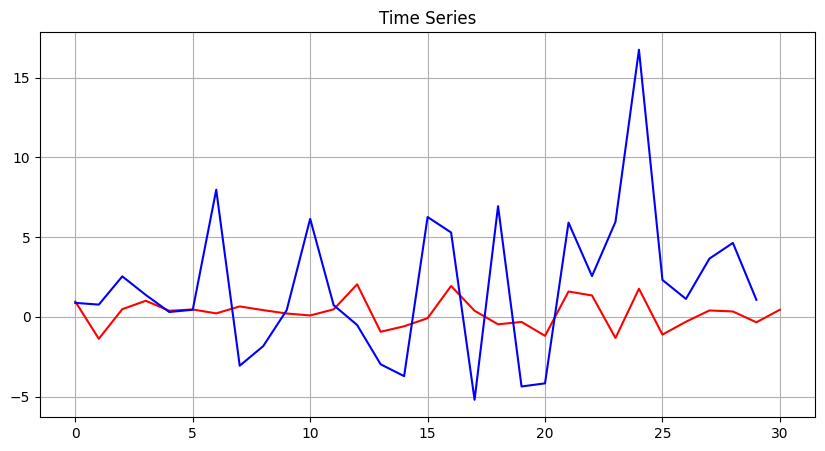

running loss: 6797.4121989020805


In [343]:
plot_predictions(x1_temperture_reduced, sarima_model_temp,start=581,end=611)
print("running loss:", calculate_loss(x1_temperture_reduced[:611], sarima_model_temp))

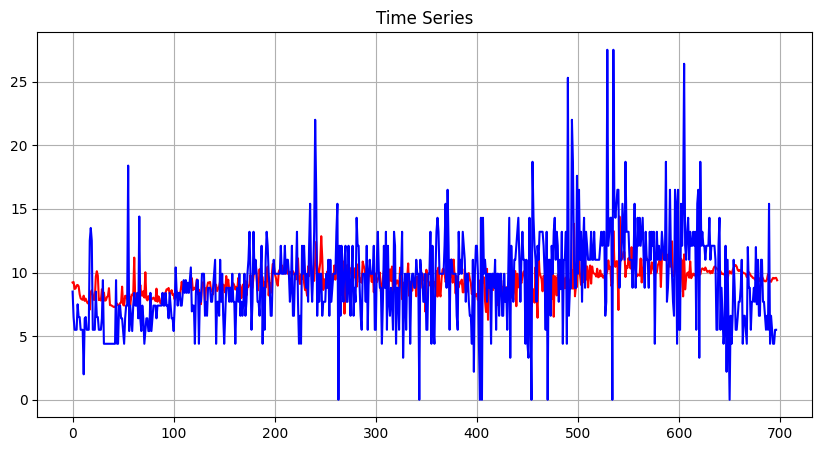

In [367]:
plot_predictions_with_temp(inverse_regressor(x1_temperture_reduced,tempreture_slope,temperture_intercept,final_tempreture),sarima_model_temp,start=0,end=697)

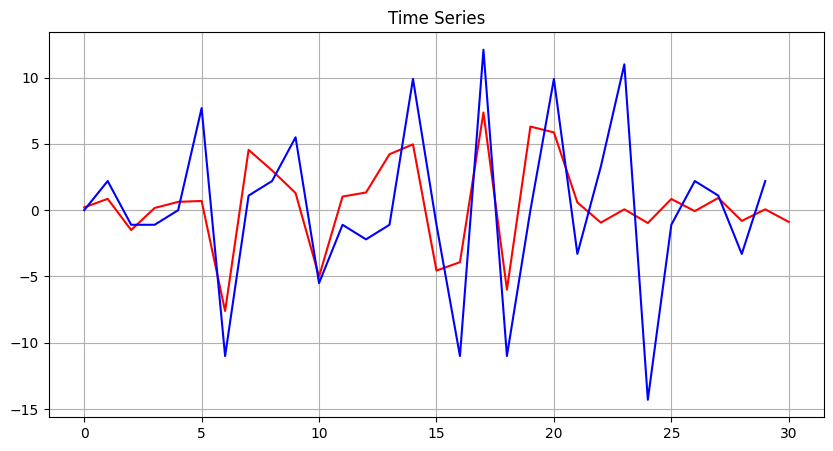

running loss: 6027.583168407369


In [332]:
plot_predictions(x1_integrated_order1, sarima_model_integrated,start=581,end=611)
print("running loss:", calculate_loss(x1_integrated_order1[:611], sarima_model_integrated))

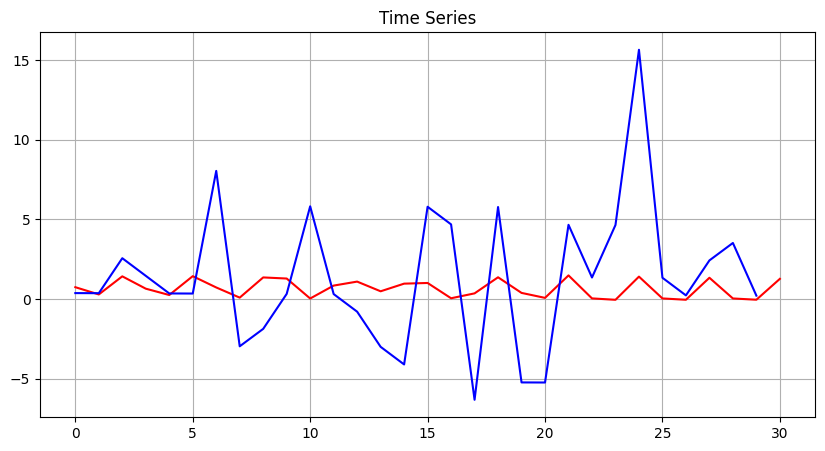

running loss: 6008.308836231658


In [333]:
plot_predictions(x1_trend_removed, sarima_model_trend_remove_1,start=581,end=611)
print("running loss:", calculate_loss(x1_trend_removed[:611], sarima_model_trend_remove_1))

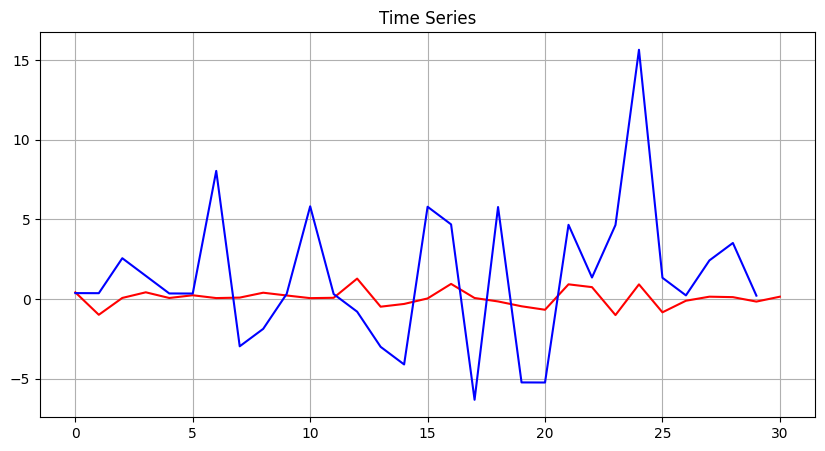

running loss: 6173.931833767867


In [334]:
plot_predictions(x1_trend_removed, sarima_model_trend_remove_2,start=581,end=611)
print("running loss:", calculate_loss(x1_trend_removed[:610], sarima_model_trend_remove_2))

# predictions of SARIMA $(0,1,1)$ X $(1,0,0)_6$

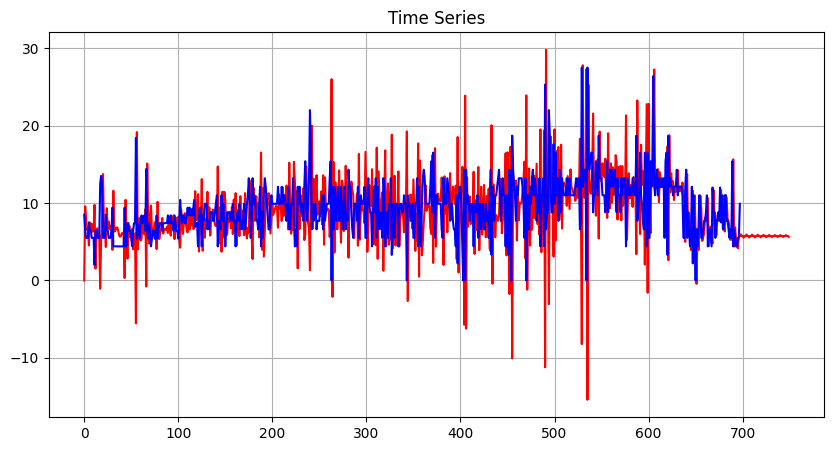

In [ ]:
plot_integrated_predictions(x1, sarima_model_integrated,start=581,end=611)

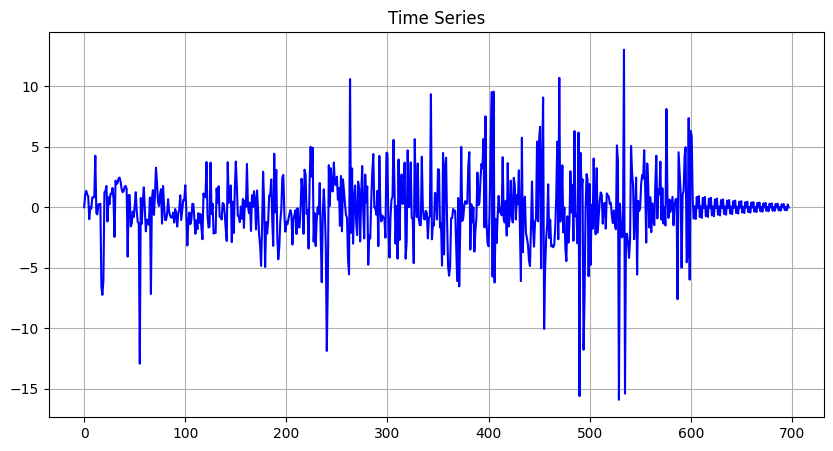

In [346]:
plot_time_series(sarima_model_integrated.predict(0, 697))

In [209]:
def plot_predictions2(data, model, start=0, end=750):
    plt.figure(figsize=(10, 5))
    plt.plot(data, color="b")
    plt.plot(np.hstack((np.zeros(data.shape[0]), model.forecast(100))), color="r")
    # plt.plot(time_series, label=f"Seasonally Differenced (s={s})", color="b")
    # plt.legend()
    plt.grid(True)
    plt.title("Time Series")
    plt.show()

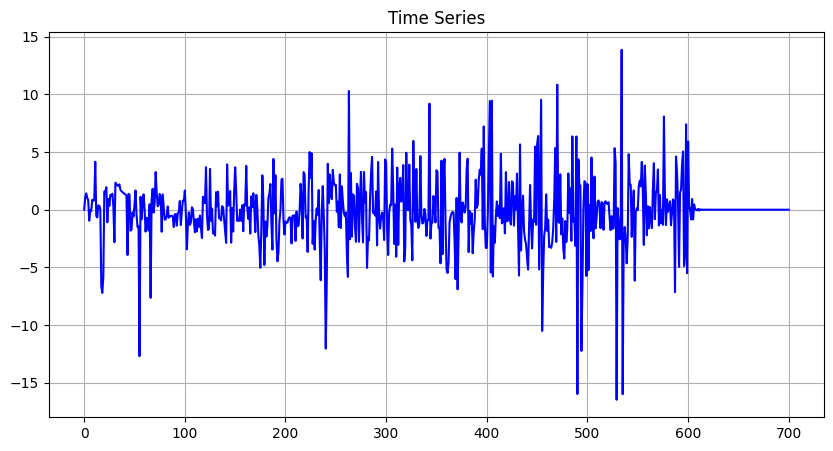

In [174]:
plot_time_series(sarima_model_integrated.predict(0, 700))

In [ ]:
dumpsters = x1
dumpsters = np.vstack((dumpsters, x2))
dumpsters = np.vstack((dumpsters, x3))
dumpsters = np.vstack((dumpsters, x4))
dumpsters = np.vstack((dumpsters, x5))
dumpsters = np.vstack((dumpsters, x6))
dumpsters = np.vstack((dumpsters, x7))
dumpsters = np.vstack((dumpsters, x8))
dumpsters = np.vstack((dumpsters, x9))
dumpsters = np.vstack((dumpsters, x10))
dumperdata = np.zeros(697//2)

dumperdata = pd.Series(np.sum(dumpsters, axis=0)).rolling(window=7).mean().dropna()
dumperdata = dumperdata.to_numpy()
print(dumperdata.shape)

(692,)


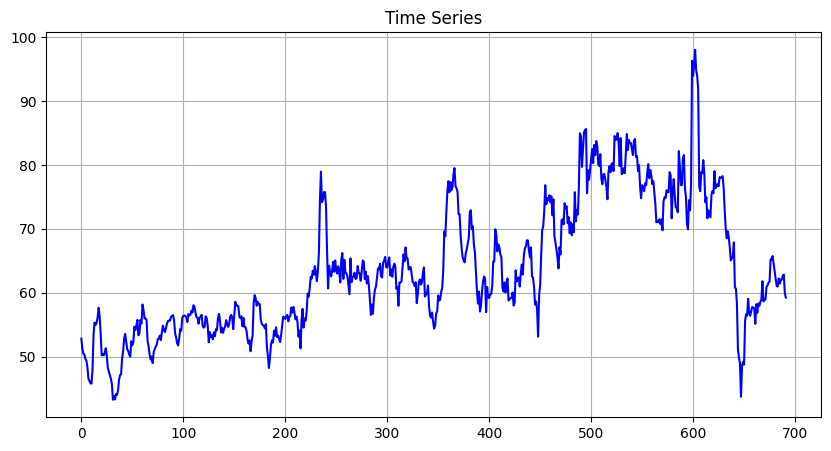

In [246]:
plot_time_series(dumperdata)

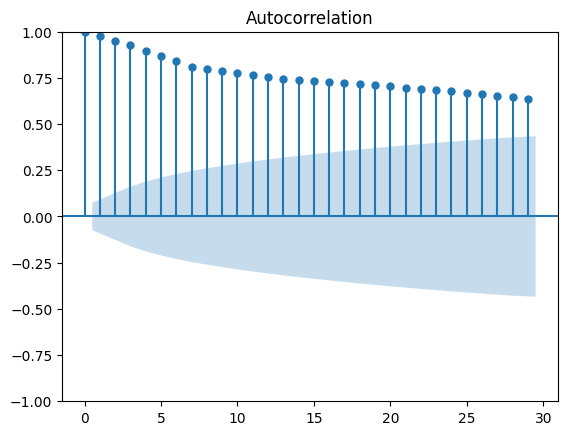

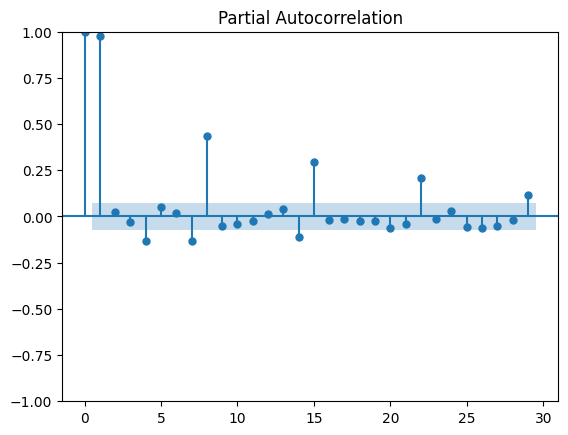

In [247]:
plot_acf(dumperdata)
plot_pacf(dumperdata)
pass

In [179]:
# from tqdm import tqdm
# def estimate_arma_by_test2(data, start_p=0, end_p=3, start_q=0, end_q=3,d_end=3, tests=('aic','bic','hqic')):
#     values = {test: {} for test in tests}
#     for q in tqdm(range(start_q, end_q)):
#         for p in range(start_p, end_p):
#             for d in range(d_end):
#                 model = ARIMA(data, order=(p, d, q))
#                 result = model.fit(method_kwargs={"warn_convergence": False})
#                 for test in tests:
#                     values[test][f"({p}, {d}, {q})"] = getattr(result, test)

#     best_orders = {}
#     for test in tests:
#         best_order = min(values[test], key=values[test].get)
#         # best_orders[test] = {"p": best_order[0], "q": best_order[1], "score": values[test][best_order], "overall_values": values[test]}
#         print(f"Best order based on {test}: {best_order} with {test}: {values[test][best_order]}")

#     return best_orders

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  600
Model:             SARIMAX(2, 0, 0)x(3, 0, [1], 7)   Log Likelihood               -1227.126
Date:                             Wed, 19 Feb 2025   AIC                           2468.252
Time:                                     13:09:47   BIC                           2499.030
Sample:                                          0   HQIC                          2480.233
                                             - 600                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0662      0.035     30.694      0.000       0.998       1.134
ar.L2         -0.0663      

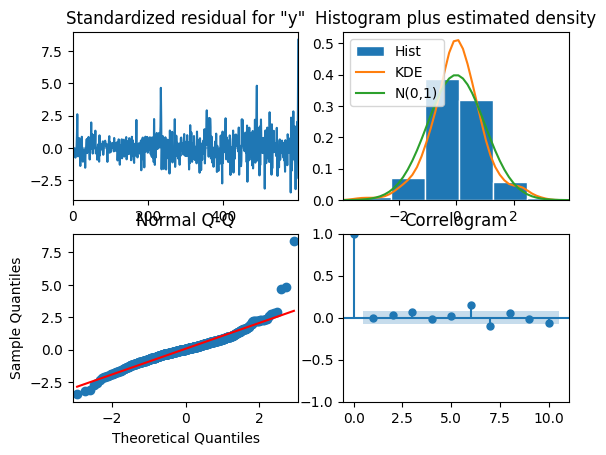

In [264]:
avarege = sarimax.SARIMAX(dumperdata[:600],
                          order=(2, 0, 0),
                          seasonal_order=(3, 0, 1, 7),
                          enforce_invertibility=True,
                          enforce_stationarity=True)

# avarege = avarege.fit(method='powell')
avarege = avarege.fit()
avarege.plot_diagnostics()
print(avarege.summary())

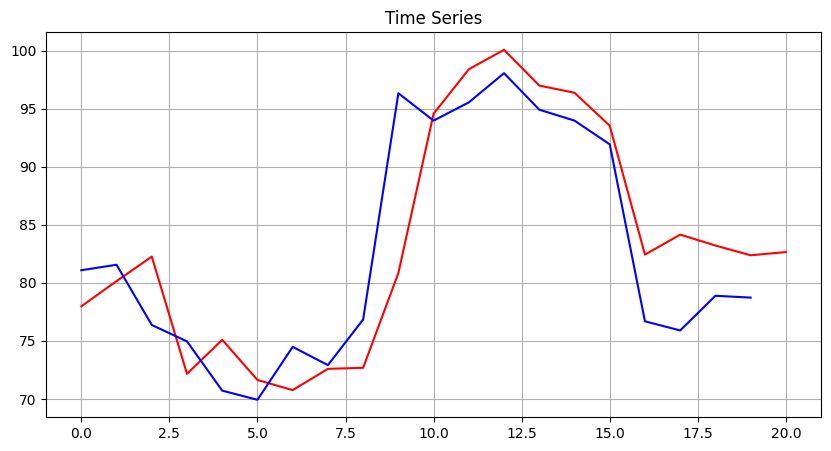

In [265]:
plot_predictions(dumperdata, avarege, start=590, end=610)

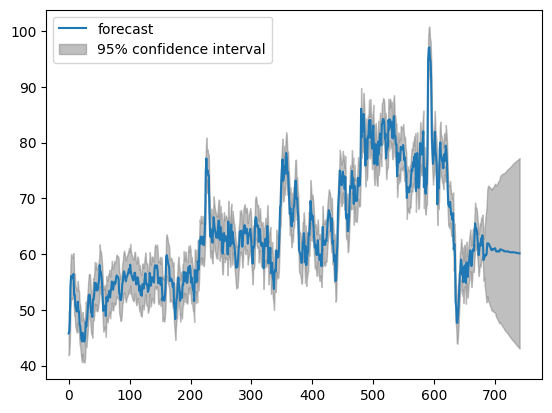

In [227]:
plot_predict(avarege,start=10,end = 750)
pass

In [222]:
print(avarege.params)
print(avarege.summary())

[ 0.52406697  0.47527929  0.54074198  0.35687944  0.32128583  0.32151262
 -0.99941233  3.62727971]
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  692
Model:             SARIMAX(2, 0, 1)x(3, 0, 1, 7)   Log Likelihood               -1432.604
Date:                           Wed, 19 Feb 2025   AIC                           2881.208
Time:                                   12:22:46   BIC                           2917.525
Sample:                                        0   HQIC                          2895.254
                                           - 692                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5241  